In [1]:
import numpy as np
import lasio
import dlisio
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
import regex

%matplotlib inline  
pd.set_option('display.max_rows', 100)
pd.set_option('mode.chained_assignment', None)
mpl.rcParams['figure.dpi'] = 150

一个函数中的功能过多可能会导致代码难以理解和维护。根据函数 merge_createname 的功能，我们可以考虑将其拆分为几个较小的函数，每个函数负责一个特定的任务。这样不仅可以提高代码的可读性，还可以使得每个函数更易于测试和重用。以下是一个可能的拆分方案：

1. 数据合并：合并两个数据集。
2. 添加或修改列：根据提供的关键字参数添加或修改列。
3. 列重排：负责重排列的顺序。
4. 深度数据处理：处理深度数据。
5. 删除不需要的列：负责删除不需要的列。
6. 替换无穷大和负无穷大值：负责替换无穷大和负无穷大值。

功能和作用：

数据整合与预处理：

- **合并测井数据**：通过`merge_createname`函数合并不同数据源(如F1A和F1A0)，整合来自同一口井的不同测井运行或来自不同口井的数据；
- **深度矫正**：调整深度数据以确定数据连贯性，特别是在合并不同数据源，深度匹配是保证数据一致性的关键；
  
数据清洗

- **去除不需要的数据列**：清理掉不相关或预定义为不需要的测量参数，保留对分析有用的数据；
- **替换无穷值**：通过替换无穷大或无穷小值
- **处理缺失数据**：根据阈值dropna，删除缺少大量数据的行，提高数据质量

特征计算

- 计算地质特征：基础原始测井数据计算新的地质特征。计算利用地质学公式或关系，为进一步地质解释和储层评估提供了重要的定量信息。

应用场景：

1. 从单个las文件中读取数据，计算地质特征，使用`merge_createname`进行数据清洗和预处理，最后根据非NAN值得数量过滤数据。集成了数据读取，特征计算，数据整理，初步数据清洗步骤，为单口井提供了一整套完整的数据处理流程；
2. 进一步展示如何从来自同一口井的不同las文件(即不同的测井序列)。分别读取和准备两个数据集，通过merge_createname合并数据，同时保留有更多有效数据的行。在需要综合多源数据以获取尽可能全面的井下信息时非常有用。

该函数，灵活强大，用于石油测井数据的整合，预处理和特征计算。

高质量的数据处理可以显著提高地质解释的准确性和效率，进而优化资源开发决策。

通过自动化步骤，节省大量时间和努力，同时减少人为错误，确保数据处理的一致性和可重复性。

In [2]:
UNWANTED = {'ABDCQF01', 'ABDCQF02', 'ABDCQF03', 'ABDCQF04', 'BVW', 'DRHO', 'NBGRCFM', 'DELTA',
                'GRMAX', 'GRMIN', 'J', 'BADDATA_FLAG', 'KLHC_INT', 'M', 'N', 'PERF_FLAG', 'PORD',
                'RHOFL', 'RHOMA', 'RW', 'SWIRR', 'RD', 'RM', 'RT', 'ROP5_RM', 'RS',
                'PHID', 'ROBB', 'ROBU', 'DRHB', 'DRHU', 'TEMP'}

In [3]:
import pandas as pd
import numpy as np
from pandas import Series

def merge_datasets(data1, data2=None):
    if data2 is not None:
        return pd.merge_asof(data1, data2, on='DEPTH', allow_exact_matches=True)
    else:
        return data1

def add_or_modify_columns(dt, **kwargs):
    # 创建一个空的DataFrame，用于处理存储处理后的数据
    result_df = pd.DataFrame()
    
    # 遍历kwargs中的每一个键值对
    for key, value in kwargs.items():
        # 为每个键值对创建一个新的DataFrame
        temp_df = dt.copy()
        # 添加或修改列
        temp_df[key] = Series(np.repeat(value, len(temp_df['DEPTH'])))
        # 将新的DataFrame添加到result_df中
        result_df = pd.concat([result_df, temp_df], ignore_index=True)
    return result_df

def rearrange_columns(dt):
    """ 
    重新排列列的顺序，将最后一列移动到第一列；
    这个操作可能会影响数据处理的顺序，特别是涉及到列依赖性的情况下。
    
    原因：
    
    在测井数据中，通常第一列是深度信息（DEPTH），这是一个关键的参数，因为它定义了测井数据的垂直位置。在进行数据分析和建模时，深度信息通常是第一列，因为它是最重要的参数，用于确定数据点在井下的位置。将最后一列（通常是一个特定的测井参数或者结果）移动到第一列，可能是为了将这个关键参数放在数据的前面，以便于后续的数据处理和分析。

    例如，如果最后一列是一个预测结果或者一个特征，将其移动到第一列可以使得在进行数据分析或可视化时，这个结果或特征更容易被注意到。这样做可以帮助数据科学家和工程师更快地识别和理解数据中的关键信息。

    另一个可能的原因是，如果数据集是从不同的源合并而来的，可能需要将一些特定的列（如深度或者井名）放在前面，以确保在进行数据处理和分析时，这些列的信息能够被正确地识别和使用。
    """
    if dt.empty:
        raise ValueError('DataFrame is empty,Cannot rearrange columns.')
    cols = dt.columns.tolist()
    # 将最后一列移动到第一列
    cols = cols[-1:] + cols[:-1]
    return dt[cols]


def calculate_new_step(well_log_df, Well):
    """
    计算新的 测井数据采样 深度步长
    如果原始数据中的深度步长为0，则使用当前深度数据的差分来计算平均步长。
    """
    # 条件判断（如STEP值是否已设置）
    if Well.well['STEP'].value == 0:
        return well_log_df['DEPTH'].diff().mean()
    else:
        return Well.well['STEP'].value

def generate_new_depth_range(well_log_df, Well):
    """ 
    生成新的深度范围
    根据开始深度、结束深度和步长来生成新的深度范围
    """
    new_step = calculate_new_step(well_log_df, Well)
    return np.arange(Well.well['STRT'].value, Well.well['STOP'].value + new_step, new_step)

def adjust_depth_data(well_log_df, Well):
    """ 
    调整深度数据
    如果新生成的深度范围与原始深度数据有显著差异，则使用新的深度范围替换原始深度数据。
    """
    original_depths = np.array(Well['DEPTH'])
    adjust_depths = generate_new_depth_range(well_log_df, Well)
    # 设定一个小的容忍阈值，以判断两个浮点数是否足够接近（如深度调整的精度判断）
    if np.abs(original_depths - adjust_depths).sum() > 1e-3:
        Well.curves['DEPTH'].data = adjust_depths
        well_log_df['DEPTH'] = adjust_depths
    return well_log_df

def remove_unwanted_columns(dt):
    unwanted_columns = set(dt.columns) & UNWANTED
    return dt.drop(columns=unwanted_columns, inplace=False)

def replace_inf_values(dt):
    dt.replace([np.inf, -np.inf], np.nan, inplace=True)
    return dt

def merge_createname(data1, data2=None, Well=None, **kwargs):
    """ 

    args:
    data1: DataFrame
    data2: DataFrame
    Well: lasio.well
    kwargs: dict

    """
    dt = merge_datasets(data1, data2)
    dt = add_or_modify_columns(dt, **kwargs)
    dt = rearrange_columns(dt)
    if Well is not None:
        dt = adjust_depth_data(dt, Well)
    dt = remove_unwanted_columns(dt)
    dt = replace_inf_values(dt)
    return dt

In [26]:
print(np.inf)

inf


In [ ]:
MIN_NON_NAN_VALUES = {
    'Well_F19A':  6,
    'Well_F19BT2':  5,
    'Well_F19SR':  4,
    'Well_F1A':  7,
    'Well_F1B':  7,
    'Well_F1C':  7,
    'Well_F1':  7,
    'Well_F11A':  7,
    'Well_F11B':  7,
    'Well_F11':  4,
    'Well_F11T2':  7,
    'Well_F12':  7,
    'Well_F15D':  8,
}

well_files = {
    'Well_F19A': ['./LAS_FILES/15_9-19_A_CPI.LAS'],
    'Well_F19BT2': ['./LAS_FILES/15_9-19_BT2_CPI.LAS'],
    'Well_F19SR': ['./LAS_FILES/15_9-19_SR_CPI.LAS'],
    'Well_F1A': ['./LAS_FILES/15_9-F-1_A_CPO.LAS', './LAS_FILES/15_9-F-1_A_CPI.LAS'],
    'Well_F1B': ['./LAS_FILES/15_9-F-1_B_CPO.LAS', './LAS_FILES/15_9-F-1_B_CPI.LAS'],
    'Well_F1C': ['./LAS_FILES/15_9-F-1_C_CPO.LAS', './LAS_FILES/15_9-F-1_C_CPI.LAS'],
    'Well_F1': ['./LAS_FILES/15_9-F-1_CPO.LAS', './LAS_FILES/15_9-F-1_CPI.LAS'],
    'Well_F11A': ['./LAS_FILES/15_9-F-11_A_CPO.LAS', './LAS_FILES/15_9-F-11_A_CPI.LAS'],
    'Well_F11B': ['./LAS_FILES/15_9-F-11_B_CPO.LAS', './LAS_FILES/15_9-F-11_B_CPI.LAS'],
    'Well_F11': ['./LAS_FILES/15_9-F-11_CPI.LAS'],
    'Well_F11T2': ['./LAS_FILES/15_9-F-11_T2_CPO.LAS', './LAS_FILES/15_9-F-11_T2_CPI.LAS'],
    'Well_F12': ['./LAS_FILES/15_9-F-12_CPO.LAS', './LAS_FILES/15_9-F-12_CPI.LAS'],
    'Well_F15D': ['./LAS_FILES/15_9-F-15D_CPO.LAS', './LAS_FILES/15_9-F-15D_CPI.LAS']
}

def read_las_file(fname):
    try:
        las_data = lasio.read(fname)
        return pd.DataFrame(las_data.data, columns=list(las_data.curvesdict.keys()))
    except Exception as e:
        print(f"Error reading file {fname}: {e}")
        return None

def process_data(df, fname):
    if match := regex.search(
        r'15_9-19_A_CPI|15_9-19_BT2_CPI|15_9-F-1_C_CPO|15_9-F-12_CPO',
        fname,
    ):
        well_id = match.group()
        if well_id == '15_9-19_A_CPI':
            df['GR'] = df['GRMAX'] - df['VSH']*(df['GRMAX']-df['GRMIN'])
            df['RHOB'] = df['RHOMA'] - df['PORD']*(df['RHOMA']-df['RHOFL'])
            df['NPHI'] = df['PORD'] + (df['PHIF']-df['PORD']-0.01)/0.4
            df['NPHI'] = df['NPHI'].abs()
            df['RPCEHM'] = df['RW']/(df['SW']**(-1/df['N']) * (df['PHIF']+0.01)**(df['M']))
        elif well_id == '15_9-19_BT2_CPI':
            df['RPCEHM'] = df['RW']/(df['SW']**(-1/2.45) * df['PHIF']**1.79)
        elif well_id == '15_9-F-1_C_CPO':
            df = df[df['BADDATA_FLAG'] != 1]
        elif well_id == '15_9-F-12_CPO':
            df.rename(columns={'RT': 'RPCEHM', 'RD': 'RPCELM'}, inplace=True)

    return df

In [5]:
well_data = {}

for well_name, files in well_files.items():
    if len(files) == 1:
        fname = files[0]
        las_data = lasio.read(fname)
        df = read_las_file(fname)
        df = process_data(df, fname)
        df = merge_createname(df, None, las_data, name=well_name)
        del las_data
    elif len(files) ==  2:
        fname1, fname2 = files
        las_data1 = lasio.read(fname1)
        df1 = read_las_file(fname1)
        las_data2 = lasio.read(fname2)
        df2 = read_las_file(fname2)
        df1 = process_data(df1, fname)
        df2 = process_data(df2, fname)
        df = merge_createname(df2, df1, las_data2, name=well_name)
        del las_data1, las_data2, df1, df2
    else:
        print(f"Unexpected number of files for well {well_name}")
        continue
    df.dropna(thresh=MIN_NON_NAN_VALUES[well_name], inplace=True)
    well_data[well_name] = df

Only engine='normal' can read wrapped files


Only engine='normal' can read wrapped files


In [6]:
for well_name, df in well_data.items():
    print("--------------------")
    print(f"{well_name}:")
    display(df)

--------------------
Well_F19A:


,name,DEPTH,BS,CARB_FLAG,COAL_FLAG,KLOGH,PHIF,SAND_FLAG,SW,VSH,GR,RHOB,NPHI,RPCEHM
0,Well_F19A,3666.5916,8.5,0.0,0.0,0.0003,0.199843,0.0,0.5590,0.598800,54.521200,2.288292,0.174843,0.279271
1,Well_F19A,3666.7440,8.5,0.0,0.0,0.0000,0.218743,0.0,0.5131,0.599555,54.444945,2.253138,0.193743,0.231091
2,Well_F19A,3666.8964,8.5,0.0,0.0,0.0000,0.242380,0.0,0.4737,0.600310,54.368690,2.209173,0.217380,0.187570
3,Well_F19A,3667.0488,8.5,0.0,0.0,0.0000,0.226408,0.0,0.5054,0.601065,54.292435,2.238881,0.201408,0.216499
4,Well_F19A,3667.2012,8.5,0.0,0.0,0.0000,0.216169,0.0,0.5360,0.601820,54.216180,2.257926,0.191169,0.240041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3003,Well_F19A,4124.2488,8.5,0.0,0.0,NaN,NaN,NaN,NaN,0.422817,NaN,NaN,NaN,NaN
3004,Well_F19A,4124.4012,8.5,0.0,0.0,NaN,NaN,NaN,NaN,0.422817,NaN,NaN,NaN,NaN
3005,Well_F19A,4124.5536,8.5,0.0,0.0,NaN,NaN,NaN,NaN,0.422817,NaN,NaN,NaN,NaN
3006,Well_F19A,4124.7060,8.5,0.0,0.0,NaN,NaN,NaN,NaN,0.422817,NaN,NaN,NaN,NaN


--------------------
Well_F19BT2:


,name,DEPTH,CARB_FLAG,COAL_FLAG,KLOGH,KLOGV,PHIF,SAND_FLAG,SW,VSH,RPCEHM
0,Well_F19BT2,3768.0900,0.0,0.0,0.0002,0.0001,0.034643,0.0,1.0000,0.6610,8.830042
1,Well_F19BT2,3768.2424,0.0,0.0,0.0001,0.0000,0.032957,0.0,1.0000,0.6946,9.654684
2,Well_F19BT2,3768.3948,0.0,0.0,0.0000,0.0000,0.010825,0.0,1.0000,0.7812,70.831481
3,Well_F19BT2,3768.5472,0.0,0.0,0.0000,0.0000,0.017037,0.0,1.0000,0.9155,31.452015
4,Well_F19BT2,3768.6996,0.0,0.0,0.0000,0.0000,0.044282,0.0,1.0000,0.9545,5.689620
...,...,...,...,...,...,...,...,...,...,...,...
2921,Well_F19BT2,4213.2504,0.0,0.0,1.6794,0.9829,0.154233,0.0,0.8036,0.8552,0.518147
2922,Well_F19BT2,4213.4028,0.0,0.0,4.9892,3.1228,0.165129,0.0,0.8901,0.7930,0.478077
2923,Well_F19BT2,4213.5552,0.0,0.0,0.8535,0.4791,0.134326,0.0,1.0000,0.6836,0.725473
2924,Well_F19BT2,4213.7076,0.0,0.0,0.9916,0.5618,0.135998,0.0,1.0000,0.6778,0.709571


--------------------
Well_F19SR:


,name,DEPTH,BWV,DT,KLOGH,KLOGV,PHIF,SAND_FLAG,SW,VSH
1,Well_F19SR,3549.8532,0.08183,54.594,NaN,NaN,NaN,NaN,NaN,NaN
2,Well_F19SR,3550.0056,0.08183,54.594,NaN,NaN,NaN,NaN,NaN,NaN
3,Well_F19SR,3550.1580,0.08183,54.594,NaN,NaN,NaN,NaN,NaN,NaN
4,Well_F19SR,3550.3104,0.08183,54.594,NaN,NaN,NaN,NaN,NaN,NaN
5,Well_F19SR,3550.4628,0.08183,54.594,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
7007,Well_F19SR,4617.5676,0.00000,40.000,0.0,NaN,0.0,0.0,1.0,NaN
7008,Well_F19SR,4617.7200,0.00000,40.000,0.0,NaN,0.0,0.0,1.0,NaN
7009,Well_F19SR,4617.8724,0.00000,40.000,0.0,NaN,0.0,0.0,1.0,NaN
7010,Well_F19SR,4618.0248,0.00000,40.000,0.0,NaN,0.0,0.0,1.0,NaN


--------------------
Well_F1A:


,name,DEPTH,BS,CALI,DT,DTS,GR,NPHI,PEF,RACEHM,...,ROP,RPCEHM,RPCELM,COAL_FLAG,KLOGH,PHIF,SAND_FLAG,SW,VCARB,VSH
801,Well_F1A,226.0,26.0,NaN,NaN,NaN,13.8931,NaN,NaN,0.7782,...,10.1142,0.6478,0.7380,NaN,NaN,NaN,NaN,NaN,NaN,NaN
802,Well_F1A,226.1,26.0,NaN,NaN,NaN,16.8323,NaN,NaN,0.8146,...,15.9918,0.8090,0.8258,NaN,NaN,NaN,NaN,NaN,NaN,NaN
803,Well_F1A,226.2,26.0,NaN,NaN,NaN,19.4866,NaN,NaN,0.8264,...,21.8538,0.9507,0.9058,NaN,NaN,NaN,NaN,NaN,NaN,NaN
804,Well_F1A,226.3,26.0,NaN,NaN,NaN,21.0532,NaN,NaN,0.8416,...,22.3173,1.0518,0.9406,NaN,NaN,NaN,NaN,NaN,NaN,NaN
805,Well_F1A,226.4,26.0,NaN,NaN,NaN,23.6296,NaN,NaN,0.8546,...,22.7807,1.0162,0.9325,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35281,Well_F1A,3674.0,8.5,NaN,NaN,NaN,116.3081,NaN,NaN,NaN,...,10.7355,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.8516
35282,Well_F1A,3674.1,8.5,NaN,NaN,NaN,116.6003,NaN,NaN,NaN,...,10.7248,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.8540
35283,Well_F1A,3674.2,8.5,NaN,NaN,NaN,116.8855,NaN,NaN,NaN,...,10.7252,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.8563
35284,Well_F1A,3674.3,8.5,NaN,NaN,NaN,113.8785,NaN,NaN,NaN,...,10.7256,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.8324


--------------------
Well_F1B:


,name,DEPTH,BS,CALI,DT,DTS,GR,NPHI,PEF,RACEHM,...,RPCEHM,RPCELM,CARB_FLAG,COAL_FLAG,KLOGH,PHIF,SAND_FLAG,SW,VCARB,VSH
24435,Well_F1B,2589.4,17.5,NaN,NaN,NaN,73.4230,NaN,NaN,0.2521,...,59878.4727,96758.3672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24436,Well_F1B,2589.5,17.5,NaN,NaN,NaN,78.6534,NaN,NaN,0.2366,...,97543.4219,55767.8125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24437,Well_F1B,2589.6,17.5,NaN,NaN,NaN,82.2872,NaN,NaN,0.2222,...,97543.4219,84936.3359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24438,Well_F1B,2589.7,17.5,NaN,NaN,NaN,90.3382,NaN,NaN,0.2301,...,97543.4219,83289.7500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24439,Well_F1B,2589.8,17.5,NaN,NaN,NaN,96.3450,NaN,NaN,0.2400,...,97471.4219,96955.1797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33108,Well_F1B,3456.7,8.5,NaN,NaN,NaN,46.8000,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.2882
33109,Well_F1B,3456.8,8.5,NaN,NaN,NaN,47.4863,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.2929
33110,Well_F1B,3456.9,8.5,NaN,NaN,NaN,50.4962,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.3136
33111,Well_F1B,3457.0,8.5,NaN,NaN,NaN,53.9392,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.3375


--------------------
Well_F1C:


,name,DEPTH,BS,CALI,GR,NPHI,PEF,RACEHM,RACELM,RHOB,ROP,RPCEHM,RPCELM,COAL_FLAG,KLOGH,PHIF,SAND_FLAG,SW,VCARB,VSH
11969,Well_F1C,1342.8,26.0,NaN,26.7013,NaN,NaN,0.5018,0.1062,NaN,21.6686,592.2389,96977.2891,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11970,Well_F1C,1342.9,26.0,NaN,26.0083,NaN,NaN,0.4289,0.1320,NaN,23.7149,65166.3477,64796.1680,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11971,Well_F1C,1343.0,26.0,NaN,25.2822,NaN,NaN,0.3902,0.1556,NaN,25.7612,97365.9063,97036.4063,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11972,Well_F1C,1343.1,26.0,NaN,27.9612,NaN,NaN,0.5050,0.1075,NaN,27.8046,556.3832,97036.4063,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11973,Well_F1C,1343.2,26.0,NaN,30.6011,NaN,NaN,0.4873,0.1020,NaN,28.6198,588.2989,96977.6406,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39445,Well_F1C,4090.4,8.5,NaN,120.3067,NaN,NaN,NaN,NaN,NaN,29.9197,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,1.0000
39446,Well_F1C,4090.5,8.5,NaN,117.1460,NaN,NaN,NaN,NaN,NaN,29.9273,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.9748
39447,Well_F1C,4090.6,8.5,NaN,116.5661,NaN,NaN,NaN,NaN,NaN,29.9291,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.9696
39448,Well_F1C,4090.7,8.5,NaN,117.6952,NaN,NaN,NaN,NaN,NaN,29.9309,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.9796


--------------------
Well_F1:


,name,DEPTH,BS,CALI,DT,GR,NPHI,PEF,RACEHM,RACELM,...,ROP,RPCEHM,RPCELM,COAL_FLAG,KLOGH,PHIF,SAND_FLAG,SW,VCARB,VSH
700,Well_F1,215.9,36.0,NaN,NaN,8.7677,NaN,NaN,0.5405,0.2689,...,NaN,0.1942,0.8712,NaN,NaN,NaN,NaN,NaN,NaN,NaN
701,Well_F1,216.0,36.0,NaN,NaN,7.9519,NaN,NaN,0.5642,0.3064,...,NaN,0.1993,0.9572,NaN,NaN,NaN,NaN,NaN,NaN,NaN
702,Well_F1,216.1,36.0,NaN,NaN,6.5373,NaN,NaN,0.4250,0.2993,...,NaN,0.1755,0.9183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
703,Well_F1,216.2,36.0,NaN,NaN,5.8048,NaN,NaN,0.4877,0.3420,...,NaN,0.1373,0.9427,NaN,NaN,NaN,NaN,NaN,NaN,NaN
704,Well_F1,216.3,36.0,NaN,NaN,6.3505,NaN,NaN,0.5296,0.2663,...,NaN,0.1106,0.7757,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34779,Well_F1,3623.8,8.5,NaN,NaN,106.8823,NaN,NaN,NaN,NaN,...,15.0267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.7656
34780,Well_F1,3623.9,8.5,NaN,NaN,109.7547,NaN,NaN,NaN,NaN,...,15.0186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.7896
34781,Well_F1,3624.0,8.5,NaN,NaN,113.8085,NaN,NaN,NaN,NaN,...,15.0105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.8234
34782,Well_F1,3624.1,8.5,NaN,NaN,116.7465,NaN,NaN,NaN,NaN,...,15.0183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.8478


--------------------
Well_F11A:


,name,DEPTH,BS,CALI,DT,DTS,GR,NPHI,PEF,RACEHM,...,ROP,RPCEHM,RPCELM,CARB_FLAG,COAL_FLAG,KLOGH,PHIF,SAND_FLAG,SW,VSH
23771,Well_F11A,2565.6,17.5,NaN,NaN,NaN,51.620,NaN,NaN,0.150,...,10.038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23772,Well_F11A,2565.7,17.5,NaN,NaN,NaN,55.199,NaN,NaN,0.148,...,10.032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23773,Well_F11A,2565.8,17.5,NaN,NaN,NaN,55.820,NaN,NaN,0.143,...,10.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23774,Well_F11A,2565.9,17.5,NaN,NaN,NaN,56.663,NaN,NaN,0.135,...,10.020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23775,Well_F11A,2566.0,17.5,NaN,NaN,NaN,57.969,NaN,NaN,0.141,...,10.024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35644,Well_F11A,3752.9,8.5,NaN,NaN,NaN,NaN,NaN,NaN,0.716,...,19.743,0.579,0.657,NaN,0.0,NaN,NaN,NaN,NaN,NaN
35645,Well_F11A,3753.0,8.5,NaN,NaN,NaN,NaN,NaN,NaN,0.683,...,19.760,0.618,0.673,NaN,0.0,NaN,NaN,NaN,NaN,NaN
35646,Well_F11A,3753.1,8.5,NaN,NaN,NaN,NaN,NaN,NaN,0.676,...,19.761,0.664,0.694,NaN,0.0,NaN,NaN,NaN,NaN,NaN
35647,Well_F11A,3753.2,8.5,NaN,NaN,NaN,NaN,NaN,NaN,0.682,...,19.762,0.715,0.717,NaN,0.0,NaN,NaN,NaN,NaN,NaN


--------------------
Well_F11B:


,name,DEPTH,BS,CALI,GR,NPHI,PEF,RACEHM,RACELM,RHOB,ROP,RPCEHM,RPCELM,CARB_FLAG,COAL_FLAG,KLOGH,PHIF,SAND_FLAG,SW,VSH
23783,Well_F11B,2566.8,17.5,NaN,59.093,NaN,NaN,0.219,0.072,NaN,10.027,603.657,122.379,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23784,Well_F11B,2566.9,17.5,NaN,60.980,NaN,NaN,0.229,0.073,NaN,10.031,56238.168,27802.186,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23785,Well_F11B,2567.0,17.5,NaN,59.999,NaN,NaN,0.223,0.072,NaN,10.034,49266.934,36701.152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23786,Well_F11B,2567.1,17.5,NaN,62.746,NaN,NaN,0.225,0.072,NaN,10.038,15291.530,14162.380,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23787,Well_F11B,2567.2,17.5,NaN,61.462,NaN,NaN,0.234,0.072,NaN,10.039,69757.789,238.071,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45724,Well_F11B,4760.9,8.5,NaN,NaN,NaN,NaN,2.492,2.283,NaN,31.543,2.373,2.257,NaN,NaN,NaN,NaN,NaN,NaN,0.776
45725,Well_F11B,4761.0,8.5,NaN,NaN,NaN,NaN,2.326,2.177,NaN,30.856,2.096,2.080,NaN,NaN,NaN,NaN,NaN,NaN,0.776
45726,Well_F11B,4761.1,8.5,NaN,NaN,NaN,NaN,2.229,2.125,NaN,30.133,1.817,1.919,NaN,NaN,NaN,NaN,NaN,NaN,0.776
45727,Well_F11B,4761.2,8.5,NaN,NaN,NaN,NaN,2.154,2.063,NaN,29.409,1.656,1.793,NaN,NaN,NaN,NaN,NaN,NaN,0.776


--------------------
Well_F11:


,name,DEPTH,BS,GR,RACEHM,RACELM,ROP,RPCEHM,RPCELM
0,Well_F11,188.5,36.0,4.3,NaN,NaN,NaN,NaN,NaN
1,Well_F11,188.6,36.0,3.8,NaN,NaN,NaN,NaN,NaN
2,Well_F11,188.7,36.0,4.3,NaN,NaN,NaN,NaN,NaN
3,Well_F11,188.8,36.0,4.6,NaN,NaN,NaN,NaN,NaN
4,Well_F11,188.9,36.0,4.6,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1578,Well_F11,346.3,26.0,NaN,NaN,NaN,42.111,NaN,NaN
1579,Well_F11,346.4,26.0,NaN,NaN,NaN,41.886,NaN,NaN
1580,Well_F11,346.5,26.0,NaN,NaN,NaN,41.660,NaN,NaN
1581,Well_F11,346.6,26.0,NaN,NaN,NaN,41.463,NaN,NaN


--------------------
Well_F11T2:


,name,DEPTH,BS,CALI,DT,DTS,GR,NPHI,PEF,RACEHM,...,ROP,RPCEHM,RPCELM,CARB_FLAG,COAL_FLAG,KLOGH,PHIF,SAND_FLAG,SW,VSH
520,Well_F11T2,240.5,26.0,NaN,NaN,NaN,24.1,NaN,NaN,1.267,...,8.488,2.194,1.692,NaN,NaN,NaN,NaN,NaN,NaN,NaN
521,Well_F11T2,240.6,26.0,NaN,NaN,NaN,23.9,NaN,NaN,1.361,...,8.498,2.346,1.824,NaN,NaN,NaN,NaN,NaN,NaN,NaN
522,Well_F11T2,240.7,26.0,NaN,NaN,NaN,23.8,NaN,NaN,1.472,...,8.471,2.393,1.918,NaN,NaN,NaN,NaN,NaN,NaN,NaN
523,Well_F11T2,240.8,26.0,NaN,NaN,NaN,24.1,NaN,NaN,1.609,...,8.444,2.327,1.991,NaN,NaN,NaN,NaN,NaN,NaN,NaN
524,Well_F11T2,240.9,26.0,NaN,NaN,NaN,23.7,NaN,NaN,1.808,...,8.417,2.405,2.112,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43641,Well_F11T2,4552.6,8.5,NaN,NaN,NaN,NaN,NaN,NaN,1.021,...,14.957,1.112,1.114,NaN,0.0,NaN,NaN,NaN,NaN,NaN
43642,Well_F11T2,4552.7,8.5,NaN,NaN,NaN,NaN,NaN,NaN,1.016,...,14.950,1.142,1.122,NaN,0.0,NaN,NaN,NaN,NaN,NaN
43643,Well_F11T2,4552.8,8.5,NaN,NaN,NaN,NaN,NaN,NaN,0.994,...,14.943,1.139,1.112,NaN,0.0,NaN,NaN,NaN,NaN,NaN
43644,Well_F11T2,4552.9,8.5,NaN,NaN,NaN,NaN,NaN,NaN,0.975,...,14.949,1.058,1.082,NaN,0.0,NaN,NaN,NaN,NaN,NaN


--------------------
Well_F12:


,name,DEPTH,CARB_FLAG,COAL_FLAG,DT,GR,NPHI,RHOB,SAND_FLAG,KLOGH,PHIF,SW,VSH
18781,Well_F12,3102.1020,0.0,0.0,77.930298,46.573299,0.3124,2.2120,0.0,0.0010,0.2699,0.0205,0.3325
18782,Well_F12,3102.2544,0.0,0.0,82.410500,47.280399,0.3189,2.2151,0.0,0.0010,0.2680,0.0131,0.3389
18783,Well_F12,3102.4068,0.0,0.0,85.986198,47.987499,0.3254,2.2181,0.0,0.0010,0.2662,0.0104,0.3453
18784,Well_F12,3102.5592,0.0,0.0,90.215897,51.266300,0.3317,2.2200,0.0,0.0010,0.2651,0.0101,0.3751
18785,Well_F12,3102.7116,0.0,0.0,89.835403,58.593700,0.3375,2.2200,0.0,0.0010,0.2651,0.0124,0.4418
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21427,Well_F12,3505.3524,0.0,0.0,NaN,80.523300,0.2040,2.4323,1.0,0.1214,0.1354,0.8984,0.4736
21428,Well_F12,3505.5048,0.0,NaN,NaN,79.315697,NaN,2.4512,1.0,NaN,NaN,0.8984,NaN
21429,Well_F12,3505.6572,0.0,NaN,NaN,79.495499,NaN,2.4877,1.0,NaN,NaN,0.8984,NaN
21430,Well_F12,3505.8096,0.0,NaN,NaN,79.675301,NaN,2.5243,1.0,NaN,NaN,0.8984,NaN


--------------------
Well_F15D:


,name,DEPTH,BS,CALI,GR,NPHI,PEF,RACEHM,RACELM,RHOB,ROP,RPCEHM,RPCELM,COAL_FLAG,KLOGH,PHIF,SAND_FLAG,SW,VCARB,VSH
12172,Well_F15D,1363.1,26.0,NaN,67.6197,NaN,NaN,0.4836,0.0988,NaN,26.0154,97400.3047,97036.4063,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12173,Well_F15D,1363.2,26.0,NaN,67.2227,NaN,NaN,0.4830,0.0999,NaN,25.5846,74109.7109,97036.4063,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12174,Well_F15D,1363.3,26.0,NaN,67.5257,NaN,NaN,0.5598,0.1087,NaN,25.1773,97543.4219,97036.4063,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12175,Well_F15D,1363.4,26.0,NaN,68.0585,NaN,NaN,0.4581,0.1484,NaN,24.8136,97465.2578,97036.4063,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12176,Well_F15D,1363.5,26.0,NaN,67.9640,NaN,NaN,0.4678,0.1211,NaN,24.5163,84680.6016,97036.4063,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45287,Well_F15D,4674.6,8.5,NaN,96.0855,NaN,NaN,3.5648,3.8462,NaN,31.1314,4.0685,3.7719,0.0,NaN,NaN,NaN,NaN,NaN,NaN
45288,Well_F15D,4674.7,8.5,NaN,95.9754,NaN,NaN,3.5086,3.7910,NaN,31.1326,4.0661,3.7322,0.0,NaN,NaN,NaN,NaN,NaN,NaN
45289,Well_F15D,4674.8,8.5,NaN,94.7469,NaN,NaN,3.4704,3.7474,NaN,31.1343,4.0411,3.6849,0.0,NaN,NaN,NaN,NaN,NaN,NaN
45290,Well_F15D,4674.9,8.5,NaN,93.5076,NaN,NaN,3.4235,3.6980,NaN,31.1368,3.9779,3.6250,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# TODO：待修复，DLTS版本变化，API更正，需要重新调整

#%%加载 DLIS 数据集的函数

def extract_data(fname):
    """
    从 DLIS 文件中提取数据

    参数:
        fname (str): DLIS 文件路径

    返回:
        pandas.DataFrame: 提取后的数据，列名对应原始数据中的曲线名称
    """
    
    f,*tail = dlisio.dlis.load(fname)
    #print(f.describe())

    logname = list(f.channels)
    name=[]
    for line in logname:
        # print('-------------------')
        # print('Channel name:', line)
        w = str(line).strip(')').split('(')
        name.append(w[1])

    combined = []
    for n in name:
        frame = f.object('CHANNEL', f'{n}')
        curve = frame.curves()
        # Convert the index to metres if needed
        if n == 'DEPTH' and frame.units == '0.1 in':
            curve = curve * 0.00254
        combined.append(curve)
    data = DataFrame(combined).T
    data.columns = name
    return data

In [8]:
well_files_dlts = {
    'Well_F4': ['./LAS_FILES/15_9-F-4_CPI.DLIS', './LAS_FILES/15_9-F-4_CPO.DLIS'],
    'Well_F5': ['./LAS_FILES/15_9-F-5_CPI.DLIS', './LAS_FILES/15_9-F-5_CPO.DLIS'],
    'Well_F10': ['./LAS_FILES/15_9-F-10_CPI.DLIS', './LAS_FILES/15_9-F-10_CPO.DLIS'],
    'Well_F14': ['./LAS_FILES/15_9-F-14_CPI.DLIS', './LAS_FILES/15_9-F-14_CPO.DLIS'],
    'Well_F15': ['./LAS_FILES/15_9-F-15_CPI.DLIS', './LAS_FILES/15_9-F-15_CPO.DLIS'],
    'Well_F15A': ['./LAS_FILES/15_9-F-15A_CPI.DLIS', './LAS_FILES/15_9-F-15A_CPO.DLIS'],
    'Well_F15B': ['./LAS_FILES/15_9-F-15B_CPI.DLIS', './LAS_FILES/15_9-F-15B_CPO.DLIS'],
    'Well_F15C': ['./LAS_FILES/15_9-F-15C_CPI.DLIS', './LAS_FILES/15_9-F-15C_CPO.DLIS'],
}

well_data_dlts = {}

for well_name, files in well_files_dlts.items():
    if len(files) ==  2:
        fname1, fname2 = files
        # CPI文件
        df1 = extract_data(fname1)
        df1.rename(columns={'RT': 'RPCEHM', 'RD': 'RPCELM'}, inplace=True)
        # CPO文件
        df2 = extract_data(fname2)
        if well_name == 'Well_F10':
            df2.drop(['RHOB'], axis=1, inplace=True)
        df = merge_createname(df1, df2, name=well_name)
        del df1, df2
    else:
        print(f"Unexpected number of files for well {well_name}")
        continue
    
    well_data_dlts[well_name] = df

In [9]:
for well_name, df in well_data_dlts.items():
    print("--------------------")
    print(f"{well_name}:")
    display(df)

--------------------
Well_F4:


,name,DEPTH,DT,DTS,GR,NPHI,RPCELM,RHOB,RPCEHM,CARB_FLAG,COAL_FLAG,KLOGH,PHIF,SAND_FLAG,SW,VSH
0,Well_F4,200.2536,-999.25,-999.25,1.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.2500
1,Well_F4,200.4060,-999.25,-999.25,1.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.2500
2,Well_F4,200.5584,-999.25,-999.25,1.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.2500
3,Well_F4,200.7108,-999.25,-999.25,1.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.2500
4,Well_F4,200.8632,-999.25,-999.25,1.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21818,Well_F4,3525.3168,-999.25,-999.25,1.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,0.4102
21819,Well_F4,3525.4692,-999.25,-999.25,1.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,0.4102
21820,Well_F4,3525.6216,-999.25,-999.25,1.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,0.4102
21821,Well_F4,3525.7740,-999.25,-999.25,1.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,0.4102


--------------------
Well_F5:


,name,DEPTH,CALI,DT,GR,NPHI,RPCELM,RHOB,RPCEHM,CARB_FLAG,COAL_FLAG,KLOGH,PHIF,SAND_FLAG,SW,VSH
0,Well_F5,421.2336,-999.25,-999.25,11.040,-999.2500,-999.25,-999.25,0.290,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
1,Well_F5,421.3860,-999.25,-999.25,11.040,-999.2500,-999.25,-999.25,0.290,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
2,Well_F5,421.5384,-999.25,-999.25,11.040,-999.2500,-999.25,-999.25,0.290,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
3,Well_F5,421.6908,-999.25,-999.25,11.040,-999.2500,-999.25,-999.25,0.290,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
4,Well_F5,421.8432,-999.25,-999.25,11.040,-999.2500,-999.25,-999.25,0.290,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22115,Well_F5,3791.5596,-999.25,-999.25,60.063,0.1368,-999.25,2.37,2.125,0.00,0.00,-999.25,-999.25,0.00,-999.25,-999.25
22116,Well_F5,3791.7120,-999.25,-999.25,60.063,0.1368,-999.25,2.37,2.125,0.00,0.00,-999.25,-999.25,0.00,-999.25,-999.25
22117,Well_F5,3791.8644,-999.25,-999.25,60.063,0.1368,-999.25,2.37,2.125,0.00,0.00,-999.25,-999.25,0.00,-999.25,-999.25
22118,Well_F5,3792.0168,-999.25,-999.25,60.063,0.1368,-999.25,2.37,2.125,0.00,0.00,-999.25,-999.25,0.00,-999.25,-999.25


--------------------
Well_F10:


,name,DEPTH,GR,NPHI,PEF,RPCELM,RHOB,RPCEHM,CARB_FLAG,COAL_FLAG,KLOGH,PHIF,SAND_FLAG,SW,VSH
0,Well_F10,4850.1300,9.790000,0.134100,5.8600,2.9700,2.5500,2.8800,0.0,0.00,338.938385,0.066265,0.00,1.00,0.00
1,Well_F10,4850.2824,11.258700,0.111510,6.0206,2.9674,2.5198,2.8824,0.0,0.00,473.663513,0.084434,0.00,1.00,0.00
2,Well_F10,4850.4348,9.910400,0.112181,6.0642,2.8106,2.5121,3.0306,0.0,0.00,516.144287,0.089096,0.00,1.00,0.00
3,Well_F10,4850.5872,8.653100,0.114753,6.1975,2.8296,2.5788,3.0496,0.0,0.00,246.289597,0.048931,0.00,1.00,0.00
4,Well_F10,4850.7396,7.310000,0.117000,5.1800,2.8300,2.5500,3.0500,0.0,0.00,338.938385,0.066265,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3083,Well_F10,5319.9792,99.957001,-999.250000,-999.2500,-999.2500,-999.2500,-999.2500,0.0,-999.25,-999.250000,-999.250000,-999.25,-999.25,-999.25
3084,Well_F10,5320.1316,101.306602,-999.250000,-999.2500,-999.2500,-999.2500,-999.2500,0.0,-999.25,-999.250000,-999.250000,-999.25,-999.25,-999.25
3085,Well_F10,5320.2840,101.029701,-999.250000,-999.2500,-999.2500,-999.2500,-999.2500,0.0,-999.25,-999.250000,-999.250000,-999.25,-999.25,-999.25
3086,Well_F10,5320.4364,102.544197,-999.250000,-999.2500,-999.2500,-999.2500,-999.2500,0.0,-999.25,-999.250000,-999.250000,-999.25,-999.25,-999.25


--------------------
Well_F14:


,name,DEPTH,DT,DTS,GR,NPHI,PEF,RPCELM,RHOB,RPCEHM,CARB_FLAG,COAL_FLAG,KLOGH,SAND_FLAG,VSH
0,Well_F14,172.5168,-999.25,-999.25,4.5204,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
1,Well_F14,172.6692,-999.25,-999.25,6.6952,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
2,Well_F14,172.8216,-999.25,-999.25,8.8701,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
3,Well_F14,172.9740,-999.25,-999.25,11.0450,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
4,Well_F14,173.1264,-999.25,-999.25,10.9670,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23469,Well_F14,3749.1924,-999.25,-999.25,-999.2500,-999.25,-999.25,-999.25,-999.25,-999.25,0.00,-999.25,-999.25,-999.25,-999.25
23470,Well_F14,3749.3448,-999.25,-999.25,-999.2500,-999.25,-999.25,-999.25,-999.25,-999.25,0.00,-999.25,-999.25,-999.25,-999.25
23471,Well_F14,3749.4972,-999.25,-999.25,-999.2500,-999.25,-999.25,-999.25,-999.25,-999.25,0.00,-999.25,-999.25,-999.25,-999.25
23472,Well_F14,3749.6496,-999.25,-999.25,-999.2500,-999.25,-999.25,-999.25,-999.25,-999.25,0.00,-999.25,-999.25,-999.25,-999.25


--------------------
Well_F15:


,name,DEPTH,CALI,DT,GR,NPHI,PEF,RPCELM,RHOB,RPCEHM,CARB_FLAG,COAL_FLAG,KLOGH,PHIF,SAND_FLAG,SW,VSH
0,Well_F15,0.0000,8.88,-999.25,-999.250000,0.615014,69.487198,-999.250,1.7783,-999.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Well_F15,0.1524,8.88,-999.25,-999.250000,0.615014,69.487198,-999.250,1.7783,-999.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Well_F15,0.3048,8.88,-999.25,-999.250000,0.615014,69.487198,-999.250,1.7783,-999.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Well_F15,0.4572,8.88,-999.25,-999.250000,0.615014,69.487198,-999.250,1.7783,-999.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Well_F15,0.6096,8.88,-999.25,-999.250000,0.615014,69.487198,-999.250,1.7783,-999.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26833,Well_F15,4089.3492,-999.25,-999.25,71.853996,0.242190,-999.250000,2.569,2.6100,2.915,1.00,0.00,0.001,0.022857,0.00,1.00,0.6401
26834,Well_F15,4089.5016,-999.25,-999.25,71.853996,0.242190,-999.250000,2.569,2.6100,2.915,1.00,0.00,0.001,0.022857,0.00,1.00,0.6401
26835,Well_F15,4089.6540,-999.25,-999.25,71.853996,0.242190,-999.250000,2.569,2.6100,2.915,1.00,0.00,0.001,0.022857,0.00,1.00,0.6401
26836,Well_F15,4089.8064,-999.25,-999.25,71.853996,0.242190,-999.250000,2.569,2.6100,2.915,1.00,0.00,0.001,0.022857,0.00,1.00,0.6401


--------------------
Well_F15A:


,name,DEPTH,CALI,DT,GR,NPHI,PEF,RPCELM,RHOB,RPCEHM,CARB_FLAG,COAL_FLAG,KLOGH,PHIF,SAND_FLAG,SW,VSH
0,Well_F15A,216.8652,-999.25,-999.25,11.647100,-999.25,-999.25,-999.25,-999.25,-999.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Well_F15A,217.0176,-999.25,-999.25,11.647100,-999.25,-999.25,-999.25,-999.25,-999.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Well_F15A,217.1700,-999.25,-999.25,13.588300,-999.25,-999.25,-999.25,-999.25,-999.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Well_F15A,217.3224,-999.25,-999.25,7.764700,-999.25,-999.25,-999.25,-999.25,-999.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Well_F15A,217.4748,-999.25,-999.25,11.647100,-999.25,-999.25,-999.25,-999.25,-999.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25384,Well_F15A,4085.3868,-999.25,-999.25,280.380798,-999.25,-999.25,-999.25,-999.25,-999.25,0.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
25385,Well_F15A,4085.5392,-999.25,-999.25,378.918793,-999.25,-999.25,-999.25,-999.25,-999.25,0.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
25386,Well_F15A,4085.6916,-999.25,-999.25,378.918793,-999.25,-999.25,-999.25,-999.25,-999.25,0.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
25387,Well_F15A,4085.8440,-999.25,-999.25,378.918793,-999.25,-999.25,-999.25,-999.25,-999.25,0.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25


--------------------
Well_F15B:


,name,DEPTH,CALI,DT,GR,NPHI,RPCELM,RHOB,RPCEHM,CARB_FLAG,COAL_FLAG,KLOGH,PHIF,SAND_FLAG,SW,VSH
0,Well_F15B,3146.9076,-999.25,56.974499,-999.250000,-999.25,-999.25,-999.25,-999.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Well_F15B,3147.0600,-999.25,56.752201,-999.250000,-999.25,-999.25,-999.25,-999.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Well_F15B,3147.2124,-999.25,57.353401,-999.250000,-999.25,-999.25,-999.25,-999.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Well_F15B,3147.3648,-999.25,57.096901,-999.250000,-999.25,-999.25,-999.25,-999.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Well_F15B,3147.5172,-999.25,57.684399,-999.250000,-999.25,-999.25,-999.25,-999.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2231,Well_F15B,3486.9120,-999.25,-999.250000,50.463699,-999.25,-999.25,-999.25,-999.25,0.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
2232,Well_F15B,3487.0644,-999.25,-999.250000,52.984299,-999.25,-999.25,-999.25,-999.25,0.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
2233,Well_F15B,3487.2168,-999.25,-999.250000,54.416500,-999.25,-999.25,-999.25,-999.25,0.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
2234,Well_F15B,3487.3692,-999.25,-999.250000,53.545399,-999.25,-999.25,-999.25,-999.25,0.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25


--------------------
Well_F15C:


,name,DEPTH,CALI,DT,GR,NPHI,RPCELM,RHOB,RPCEHM,CARB_FLAG,COAL_FLAG,KLOGH,PHIF,SAND_FLAG,SW,VSH
0,Well_F15C,2560.0152,-999.25,-999.25,41.575001,-999.25,0.1500,-999.25,230.929703,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Well_F15C,2560.1676,-999.25,-999.25,37.451199,-999.25,0.1399,-999.25,167.451797,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Well_F15C,2560.3200,-999.25,-999.25,34.842201,-999.25,0.1281,-999.25,5000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Well_F15C,2560.4724,-999.25,-999.25,33.720100,-999.25,0.2128,-999.25,5000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Well_F15C,2560.6248,-999.25,-999.25,34.645802,-999.25,0.1958,-999.25,5000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4341,Well_F15C,3221.5836,-999.25,-999.25,59.553200,-999.25,-999.2500,-999.25,-999.250000,0.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
4342,Well_F15C,3221.7360,-999.25,-999.25,63.495399,-999.25,-999.2500,-999.25,-999.250000,0.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
4343,Well_F15C,3221.8884,-999.25,-999.25,62.397999,-999.25,-999.2500,-999.25,-999.250000,0.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
4344,Well_F15C,3222.0408,-999.25,-999.25,59.277901,-999.25,-999.2500,-999.25,-999.250000,0.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25


In [18]:
#%% `group`合并所有数据集

#　合并LAS和DLIS数据集
data_final_las = pd.concat([well_data[well_name] for well_name in well_data], axis=0,sort=False)
data_final_dlts = pd.concat([well_data_dlts[well_name] for well_name in well_data_dlts], axis=0,sort=False)
data_final = pd.concat([data_final_las, data_final_dlts], axis=0,sort=False)

# 统一电阻率列名
data_final.rename(columns = {'RPCEHM':'RM','RPCELM':'RD'}, inplace=True)
# 重新排序列
data_final = data_final.reindex(columns=['name', 'DEPTH', 'GR', 'BS', 'CALI', 'ROP', 'RHOB',
                                         'NPHI', 'RACEHM', 'RACELM', 'RM', 'RD', 'PEF', 'DT', 'DTS',
                                         'VCARB', 'VSH', 'PHIF', 'SW', 'KLOGH', 'KLOGV', 'SAND_FLAG',
                                         'CARB_FLAG', 'COAL_FLAG'])

# `delete`删除`out of range`异常值
data_final.loc[:,'NPHI'][data_final.loc[:,'NPHI']>0.6]=np.nan # # NPHI 大于 0.6 的值置为空值
data_final.loc[:,'NPHI'][data_final.loc[:,'NPHI']<-0.15]=np.nan
data_final.loc[:,'VSH'][data_final.loc[:,'VSH']<0]=np.nan
data_final.loc[:,'VSH'][data_final.loc[:,'VSH']>1]=np.nan
data_final.loc[:,'SW'][data_final.loc[:,'SW']<0]=np.nan
data_final.loc[:,'SW'][data_final.loc[:,'SW']>1]=np.nan
data_final.loc[:,'PHIF'][data_final.loc[:,'PHIF']>1.0]=np.nan
data_final.loc[:,'PHIF'][data_final.loc[:,'PHIF']<0.0]=np.nan

In [19]:
n_wells=data_final['name'].unique()
print(n_wells)
len(n_wells)

['Well_F19A' 'Well_F19BT2' 'Well_F19SR' 'Well_F1A' 'Well_F1B' 'Well_F1C'
 'Well_F1' 'Well_F11A' 'Well_F11B' 'Well_F11' 'Well_F11T2' 'Well_F12'
 'Well_F15D' 'Well_F4' 'Well_F5' 'Well_F10' 'Well_F14' 'Well_F15'
 'Well_F15A' 'Well_F15B' 'Well_F15C']


21

这段代码是一个测井曲线绘图的函数，专门设计用于可视化油井测井数据。这种类型的可视化对于地质学家和石油工程师来说是非常重要的，因为它们可以通过测井曲线来解读地下岩石的性质和可能含有的流体（如油、水和气）。以下是对这个函数及其在石油测井领域中应用的分析：

### 功能概述
- **数据排序和深度范围设置**：函数首先按照深度排序测井数据，然后根据提供的`depths`参数或者数据的最小和最大深度来设置绘图的深度范围。
- **绘图轴的设置**：创建了一个包含7个子图（tracks）的绘图，每个轴（或"track"）用于显示不同的测井参数，如伽玛射线（GR）、口径（CALI）、钻进速率（ROP）、密度（RHOB）、中子孔隙度（NPHI）、电阻率（RES）、声波时差（DTC/DTS）等。
- **自定义深度范围和保存选项**：用户可以通过`kwargs`指定特定的深度范围进行绘图，并有选项保存生成的图像。

### 领域相关的知识
- **GR、CALI、ROP**等参数的展示对于识别岩石类型和钻井效率至关重要。例如，伽玛射线用于识别页岩和非页岩层，口径测量可以指示井孔大小和形状，而钻进速率提供了钻井过程的信息。
- **RHOB 和 NPHI**用于评估岩石的密度和孔隙度，是评价油气藏的关键参数。
- **电阻率（如RACEHM、RACELM、RM、RD）**的测量对于评估地层的含水饱和度非常重要，因为油、气和水的电阻率差异显著。
- **声波时差（DT、DTS）**和**光电吸收系数（PEF）**提供了关于岩石弹性和矿物组成的信息。
- **孔隙度（PHIF）、含砂量（VSH）、碳酸盐含量（VCARB）**以及特定的地层标志（如砂岩、碳酸盐岩、煤层标志）用于进一步的岩石物理特性分析。

### 绘图实现的技术细节
- 使用`matplotlib`库的`subplots`和`twiny`方法来创建共享y轴（深度轴）但具有独立x轴（测量值）的多个图轴。
- 每个轴通过不同的颜色和标签展示不同的测井参数，增加了可读性和分析的方便性。
- 部分参数如电阻率和渗透率使用对数刻度来增强展示效果，因为这些参数的变化范围很广。
- 对于某些参数（如VSH和VCARB），还通过填充颜色在深度轴上直观显示了参数值的分布。

### 总结
这个绘图函数是一个非常强大的工具，用于将复杂的测井数据以图形形式直观展示，支持地质学和油田开发的决策。

In [36]:

import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style for the plots
sns.set_style("whitegrid")


#%% Plotting function
def well_log_plot(well_logs,**kwargs):
    # Sort well_logs by depth
    
    # 1. 排序和深度范围设置：
    well_logs = well_logs.sort_values(by='DEPTH')
    dtop=well_logs.DEPTH.min()
    dbot=well_logs.DEPTH.max()
    depths=kwargs.setdefault('depths',[dtop,dbot])
    
    savefile=kwargs.setdefault('savefig',"")
    # 检查 depths 参数是否包含特殊值 'TOP' 或 'BOTTOM'，如果包含，则替换为实际的深度值,
    # 如果是，则根据PHIF列的值来确定深度范围，第一个和最后一个非空值来设置范围。
    if depths[0] in ['TOP','topfm'] or depths[-1] in ['BOTTOM','bottomfm']:
        if well_logs.PHIF.isnull().sum()!=len(well_logs):
            depths[0]=well_logs.DEPTH[well_logs.PHIF.first_valid_index()]  #make the first non-NA/null value in PHIF column
            if depths[0]>=dbot:
                depths[0]=dtop
            depths[-1] = max(well_logs.DEPTH[well_logs.PHIF.last_valid_index()], dbot)
        else:
            depths[0]=dtop
            depths[-1]=dbot
    elif depths[-1]>dbot:
        depths[-1]=dbot
    elif depths[0]<dtop:
        depths[0]=dtop
        
    # 2. 图像设置：
    #　７个子图的图像，子图共享ｙ轴（深度）
    fig, axs = plt.subplots(nrows=1, ncols=7, sharey=True, squeeze=True, figsize=(15, 10), gridspec_kw={'wspace': 0.25})
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.975, top=0.7, wspace=0.2, hspace=0.2)
    axs[0].set_ylabel('Depth (m)')
    #　子图的ｙ轴范围设置为　depths 参数指定的范围，并且y轴方向反转
    #　子图的ｘ轴被隐藏，以便只显示ｙ轴（深度）
    for ax in axs:
        ax.set_ylim(depths[0],depths[-1])
        ax.invert_yaxis()
        ax.grid(True)
        ax.locator_params(axis='x', nbins=5)
        ax.get_xaxis().set_visible(False)

    # 3. 绘制测井数据:
    # twiny 方法在子图上创建多个x轴，每个x轴对应一个不同的测井数据列；
    # 对于每个测井数据列，函数绘制了一条线，并设置了x轴的范围和标签。
    # 对于某些测井数据列，函数还使用了 fill_betweenx 方法，用于填充两个数据列之间的区域。以表示特定条件下的测井数据。
    # First track GR/CALI/ROP logs to display
    
    # 获得seaborn的颜色
    palette = sns.color_palette("husl", 3)  # 获取3种颜色
    colors = {'GR': palette[0], 'CALI': palette[1], 'ROP': palette[2]}
    
    ax1 = axs[0].twiny()
    ax1.plot(well_logs.GR, well_logs.DEPTH, '-', color=colors['GR']) 
    ax1.set_xlim(0,150)
    ax1.set_xlabel('GR (API)', color= colors['GR'])
    ax1.minorticks_on()
    ax1.tick_params(axis='x', color=colors['GR'])        
    ax1.spines['top'].set_position(("axes", 1.15)) # Move the last y-axis spine over to the top by 20% of the width of the axes

    ax2 = axs[0].twiny()
    ax2.plot(well_logs.CALI, well_logs.DEPTH, '-', color=colors['CALI'])
    ax2.set_xlim(0,13)
    ax2.set_xlabel('CALI (In)', color= colors['CALI'])
    ax2.minorticks_on()
    ax2.tick_params(axis='x', color= colors['CALI'])
    ax2.spines['top'].set_position(("axes", 1.075))

    ax3 = axs[0].twiny()
    ax3.plot(well_logs.ROP, well_logs.DEPTH, '-', color= colors['ROP'])
    ax3.set_xlim(100,0)
    ax3.set_xlabel('ROP (m/hr)', color= colors['ROP'])
    ax3.minorticks_on()
    ax3.tick_params(axis='x', color= colors['ROP'])
    ax3.spines['top'].set_position(("axes", 1.0))

    # Second track NPHI/RHOB logs to display
    
    # 获得seaborn的颜色
    palette = sns.color_palette("Set1", 2)  # 获取2种颜色
    colors = {'RHOB': palette[0], 'NPHI': palette[1]}
    
    ax1 = axs[1].twiny()
    ax1.plot(well_logs.RHOB, well_logs.DEPTH, '-', color= colors['RHOB'])
    ax1.set_xlim(1.5,3)
    ax1.set_xlabel('RHOB (g/cm3)', color= colors['RHOB'])
    ax1.tick_params(axis='x', colors= colors['RHOB'])
    ax1.minorticks_on()
    ax1.spines['top'].set_position(("axes", 1.075))

    ax2 = axs[1].twiny()
    ax2.plot(well_logs.NPHI, well_logs.DEPTH, '-', color= colors['NPHI'])
    ax2.set_xlim(0.6,-0.1)
    ax2.set_xlabel('NPHI (v/v)', color= colors['NPHI'])
    ax2.tick_params(axis='x', color= colors['NPHI'])
    ax2.minorticks_on()
    ax2.spines['top'].set_position(("axes", 1.0))

    # Third track Resistivity logs to display
    palette = sns.color_palette("husl", 4)  # 获取4种颜色
    colors = {'RACEHM': palette[0], 'RACELM': palette[1], 'RM': palette[2], 'RD': palette[3]}
    
    ax1 = axs[2].twiny()
    ax1.plot(well_logs.RACEHM, well_logs.DEPTH, '-', color= colors['RACEHM'] )
    ax1.grid(True)
    ax1.set_xlim(0.1,2000)
    ax1.set_xlabel('RACEHM (ohm.m)', color= colors['RACEHM'] )
    ax1.tick_params(axis='x', color= colors['RACEHM'])
    ax1.set_xscale('log')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(("axes", 1.075))

    ax2 = axs[2].twiny()
    ax2.plot(well_logs.RACELM, well_logs.DEPTH, '-', color= colors['RACELM'])
    ax2.set_xlim(0.1,2000)
    ax2.set_xlabel('RACELM (ohm.m)', color= colors['RACELM'])
    ax2.tick_params(axis='x', colors= colors['RACELM'])
    ax2.set_xscale('log')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(("axes", 1.15))

    ax3 = axs[2].twiny()
    ax3.plot(well_logs.RM, well_logs.DEPTH, '-', color= colors['RM'])
    ax3.set_xlim(0.1,2000)
    ax3.set_xlabel('RM (ohm.m)', color= colors['RM'])
    ax3.tick_params(axis='x', color= colors['RM'])
    ax3.set_xscale('log')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(("axes", 1.225))

    ax4 = axs[2].twiny()
    ax4.plot(well_logs.RD, well_logs.DEPTH, '-', color= colors['RD'])
    ax4.set_xlim(0.1,2000)
    ax4.set_xlabel('RD (ohm.m)', color= colors['RD'])
    ax4.tick_params(axis='x', color= colors['RD'])
    ax4.set_xscale('log')
    ax4.minorticks_on()
    ax4.spines['top'].set_position(("axes", 1.0))

    # Forth track DTC/DTS/PEF logs to display
    palette = sns.color_palette("husl", 3)  # 获取3种颜色
    colors = {'PEF': palette[0], 'DT': palette[1], 'DTS': palette[2]}
    
    ax1 = axs[3].twiny()
    ax1.plot(well_logs.PEF, well_logs.DEPTH, '-', color= colors['PEF'] )
    ax1.set_xlim(15,0)
    ax1.set_xlabel('PE (b/elec)', color= colors['PEF'] )
    ax1.tick_params(axis='x', color= colors['PEF'])
    ax1.minorticks_on()
    ax1.spines['top'].set_position(("axes", 1.0))

    ax2 = axs[3].twiny()
    ax2.plot(well_logs.DT, well_logs.DEPTH, '-', color= colors['DT'] )
    ax2.set_xlim(140,40)
    ax2.set_xlabel('DT (us/ft)', color= colors['DT'] )
    ax2.tick_params(axis='x', colors= colors['DT'])
    ax2.minorticks_on()
    ax2.spines['top'].set_position(("axes", 1.15))

    ax3 = axs[3].twiny()
    ax3.plot(well_logs.DTS, well_logs.DEPTH, '-', color= colors['DTS'] )
    ax3.set_xlim(240,40)
    ax3.set_xlabel('DTS (us/ft)', color= colors['DTS'] )
    ax3.tick_params(axis='x', color = colors['DTS'])
    ax3.minorticks_on()
    ax3.spines['top'].set_position(("axes", 1.075))

    # Fifth track PHIF logs to display
    palette = sns.color_palette("husl", 3)  # 获取3种颜色
    colors = {'PHIF': palette[0], 'VSH': palette[1], 'VCARB': palette[2]}
    
    ax1 = axs[4].twiny()
    ax1.plot(well_logs.PHIF, well_logs.DEPTH, '-', color= colors['PHIF'])
    ax1.set_xlim(0,0.5)
    ax1.grid(True)
    ax1.set_xlabel('PHIF (v/v)', color= colors['PHIF'])
    ax1.tick_params(axis='x', color= colors['PHIF'])
    ax1.minorticks_on()
    ax1.spines['top'].set_position(("axes", 1.225))

    ax2 = axs[4].twiny()
    ax2.plot(well_logs.VSH, well_logs.DEPTH, '-', color= colors['VSH'])
    ax2.set_xlim(1.5,0)
    ax2.set_xlabel('VSH', color= colors['VSH'])
    ax2.tick_params(axis='x', color= colors['VSH'])
    ax2.minorticks_on()
    ax2.spines['top'].set_position(("axes", 1.15))
    ax2.fill_betweenx(well_logs.DEPTH, well_logs.VSH, 0, where=(well_logs.VSH > 0), color='palegoldenrod', alpha=0.2)

    ax4 = axs[4].twiny()
    ax4.plot(well_logs.VCARB, well_logs.DEPTH, '-', color= colors['VCARB'])
    ax4.set_xlim(1.5,0)
    ax4.set_xlabel('VCARB', color= colors['VCARB'])
    ax4.tick_params(axis='x', color= colors['VCARB'])
    ax4.minorticks_on()
    ax4.spines['top'].set_position(("axes", 1.075))
    ax4.fill_betweenx(well_logs.DEPTH, well_logs.VCARB, 0, where=(well_logs.VCARB > 0), color='olivedrab', alpha=0.2)

    ax3 = axs[4].twiny()
    ax3.fill_betweenx(well_logs.DEPTH, well_logs.SAND_FLAG, 0, where=(well_logs.SAND_FLAG > 0), color='red')
    ax3.fill_betweenx(well_logs.DEPTH, well_logs.CARB_FLAG, 0, where=(well_logs.CARB_FLAG > 0), color='lime')
    ax3.fill_betweenx(well_logs.DEPTH, well_logs.COAL_FLAG, 0, where=(well_logs.COAL_FLAG > 0), color='black')
    ax3.set_xlim(10,0)
    ax3.set_xlabel('FLAG-SAND|CARB')
    ax3.tick_params(axis='x')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(("axes", 1.0))

    # Sixth track SW logs to display
    ax1 = axs[5].twiny()
    ax1.plot(well_logs.SW, well_logs.DEPTH, '-', color='royalblue')
    ax1.grid(True)
    ax1.set_xlim(0,1)
    ax1.set_xlabel('SW (v/v)', color='royalblue')
    ax1.tick_params(axis='x', color='royalblue')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(("axes", 1.0))
    ax1.fill_betweenx(
        well_logs.DEPTH,
        well_logs.SW,
        1,
        where=well_logs.SW <= 1,
        color='green',
        alpha=0.5,
    )

    # Seventh track KLOGH/KLOGV logs to display
    ax1 = axs[6].twiny()
    ax1.set_xscale('log')
    ax1.grid(True)
    ax1.plot(well_logs.KLOGH, well_logs.DEPTH, '-', color='steelblue')
    ax1.set_xlim(0.01,10000)
    ax1.set_xlabel('KLOGH (mD)', color='steelblue')
    ax1.tick_params(axis='x', color='steelblue')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(("axes", 1.075))

    ax2 = axs[6].twiny()
    ax2.set_xscale('log')
    ax2.plot(well_logs.KLOGV, well_logs.DEPTH, '-', color='maroon')
    ax2.set_xlim(0.01,10000)
    ax2.set_xlabel('KLOGV (mD)', color='maroon')
    ax2.tick_params(axis='x', color='maroon')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(("axes", 1.0))

    # 4 图像标题和保存：
    # 函数设置了图像的标题，标题包含了测井数据的名称
    # 如果 savefile 参数包含了文件名，则函数将图像保存到指定的文件中
    fig.suptitle(
        f"Log Petrophysical display for {well_logs.iloc[0]['name']}",
        weight='bold',
        fontsize=20,
        y=0.925,
    )
    if len(savefile)>0:
        fig.savefig(savefile,dpi=300)

In [38]:
n_wells=data_final['name'].unique()
print(n_wells)
len(n_wells)

['Well_F19A' 'Well_F19BT2' 'Well_F19SR' 'Well_F1A' 'Well_F1B' 'Well_F1C'
 'Well_F1' 'Well_F11A' 'Well_F11B' 'Well_F11' 'Well_F11T2' 'Well_F12'
 'Well_F15D' 'Well_F4' 'Well_F5' 'Well_F10' 'Well_F14' 'Well_F15'
 'Well_F15A' 'Well_F15B' 'Well_F15C']


21

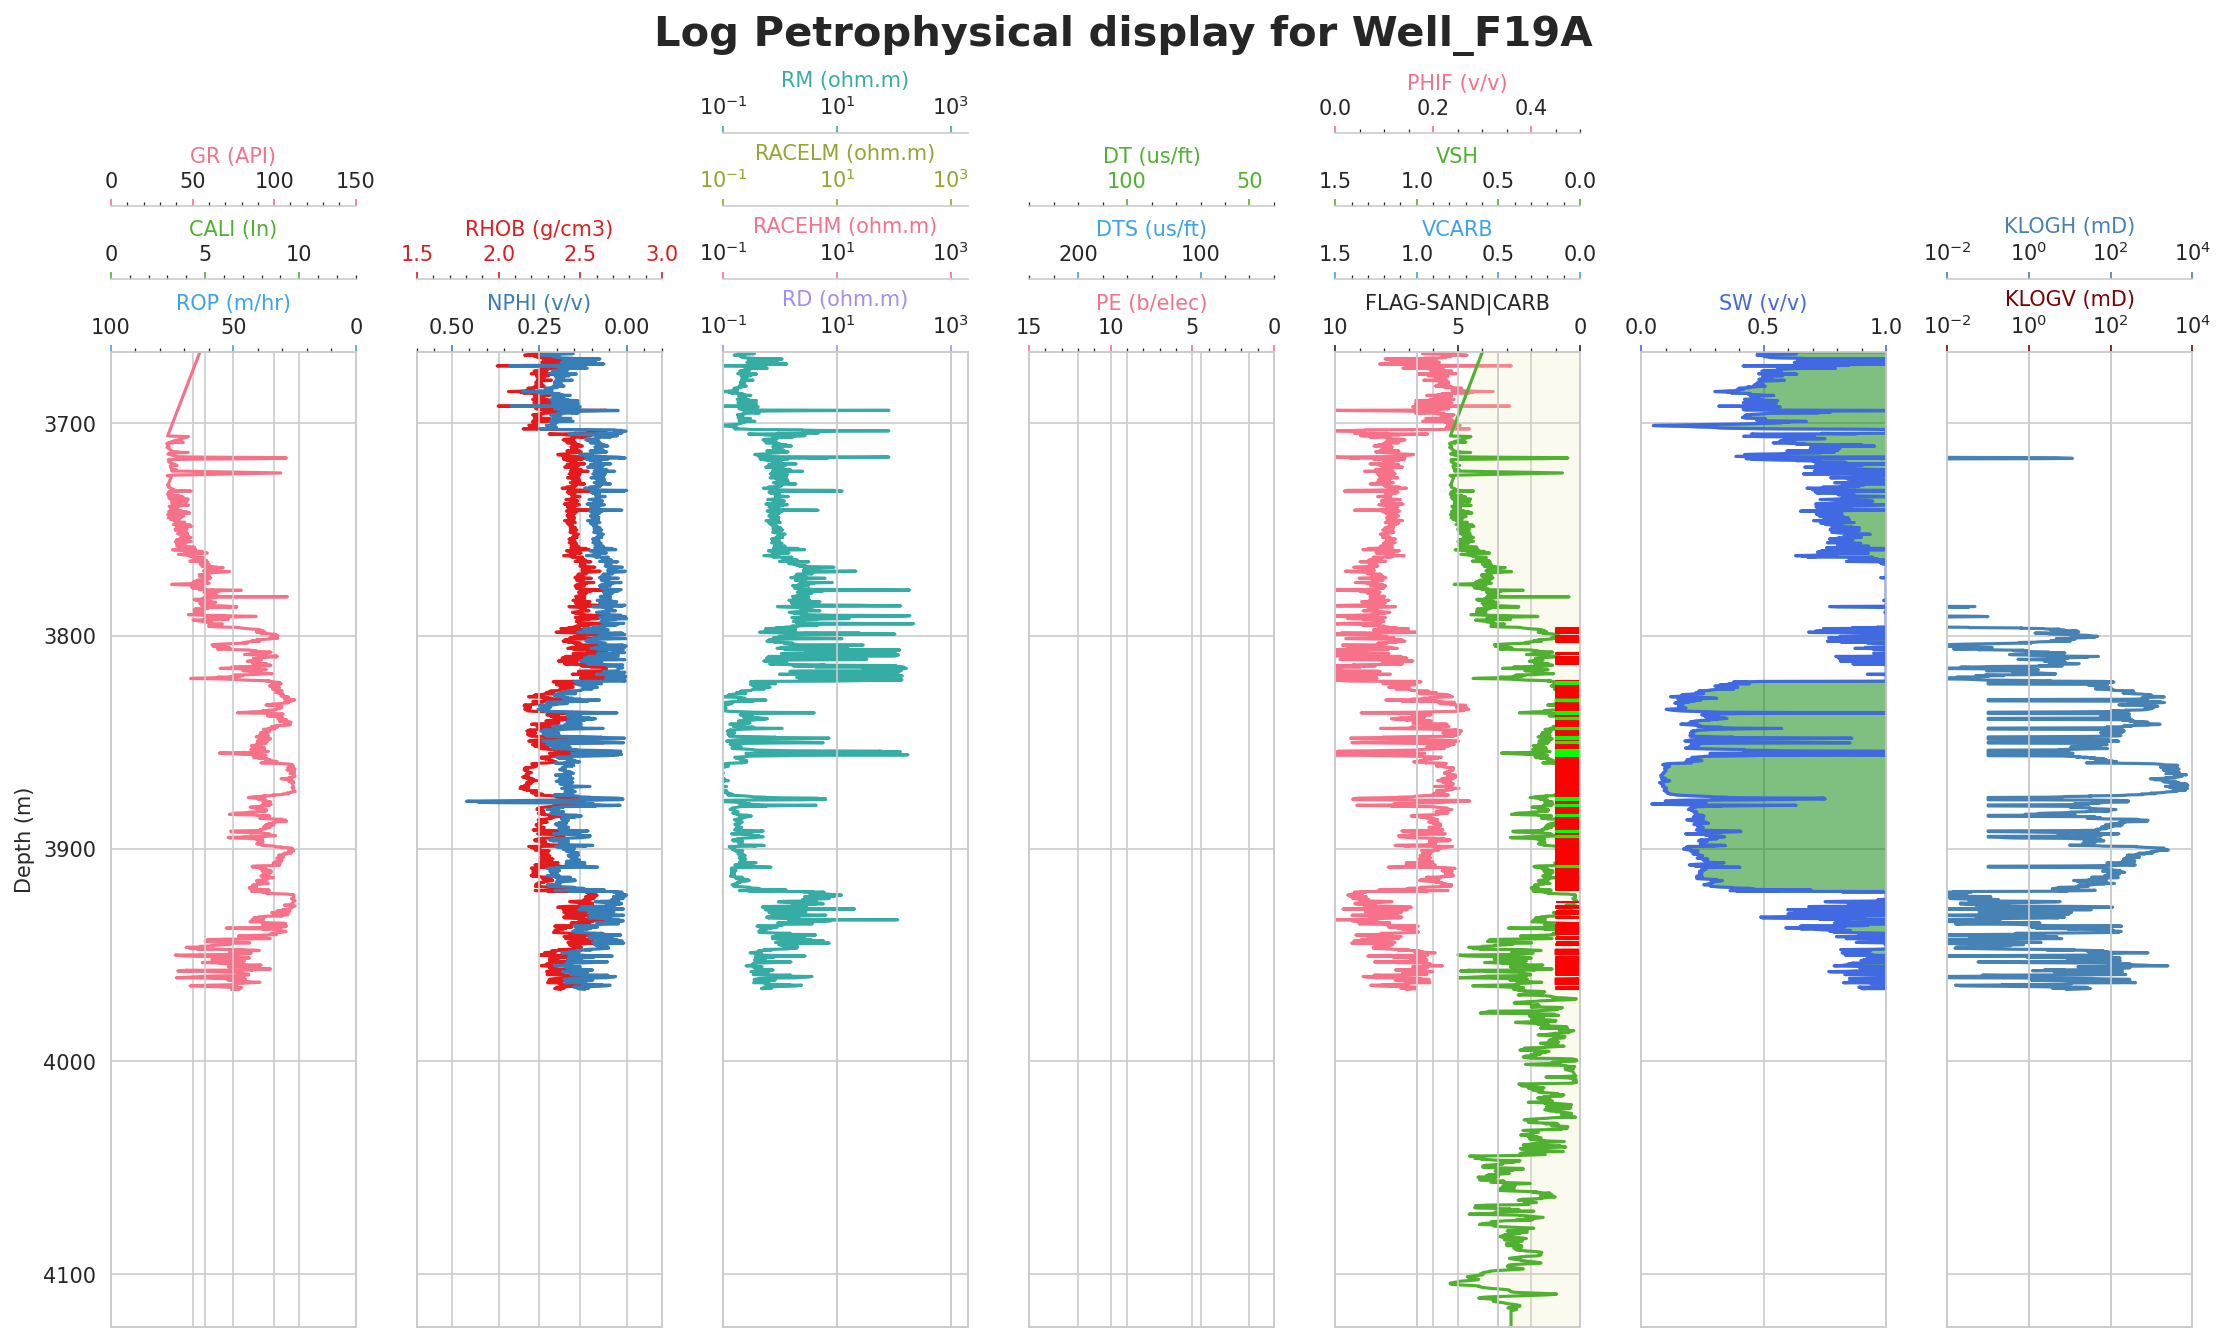

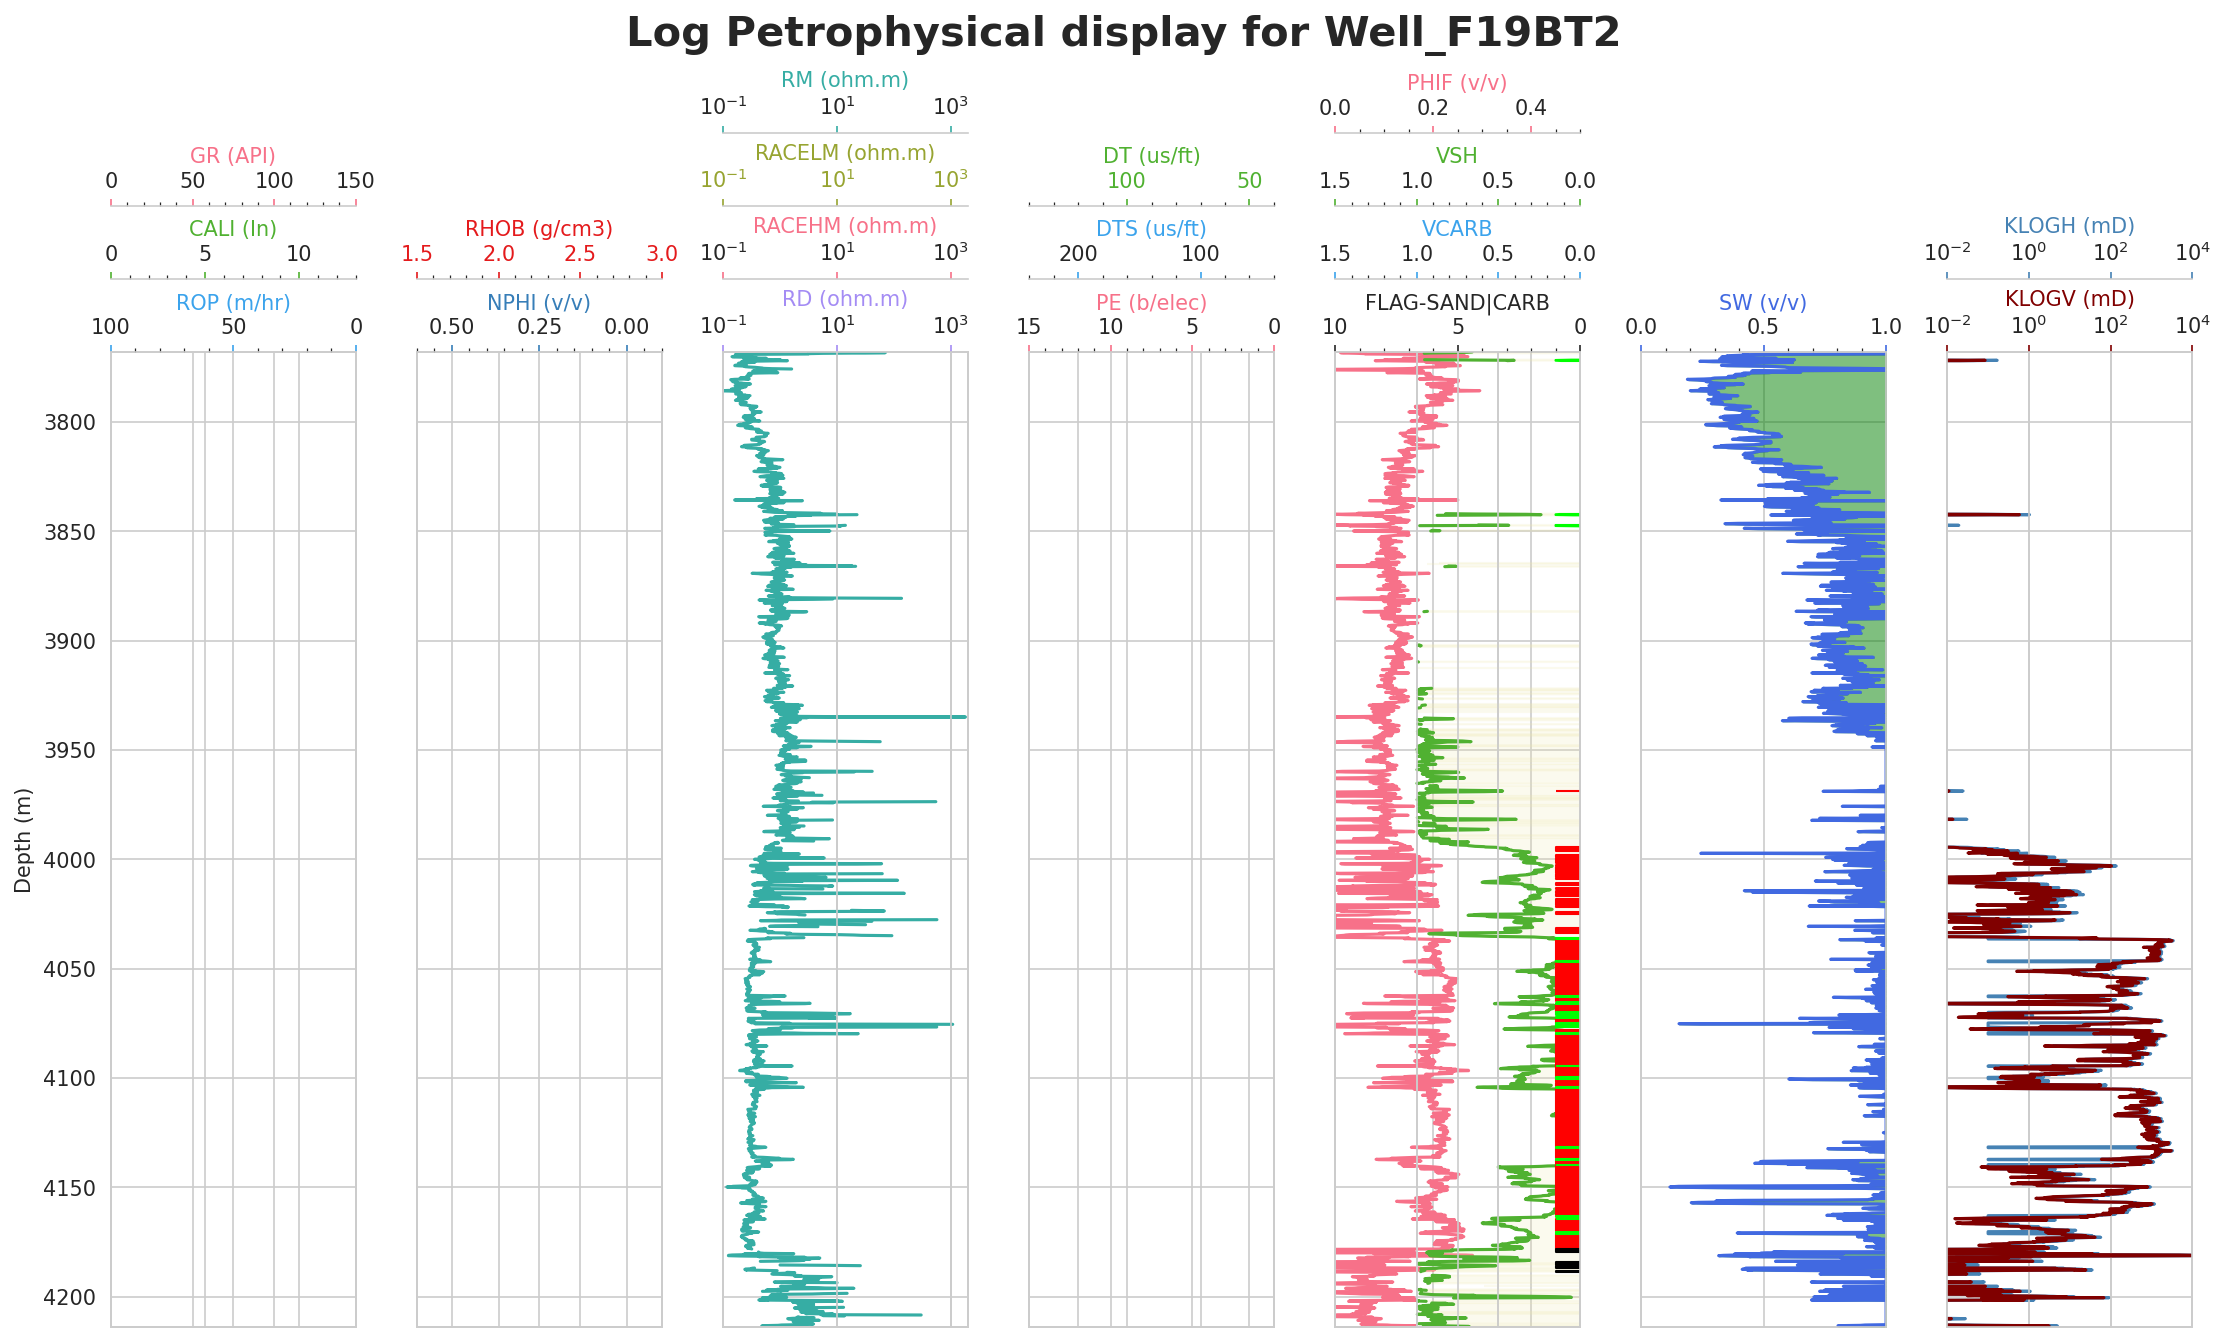

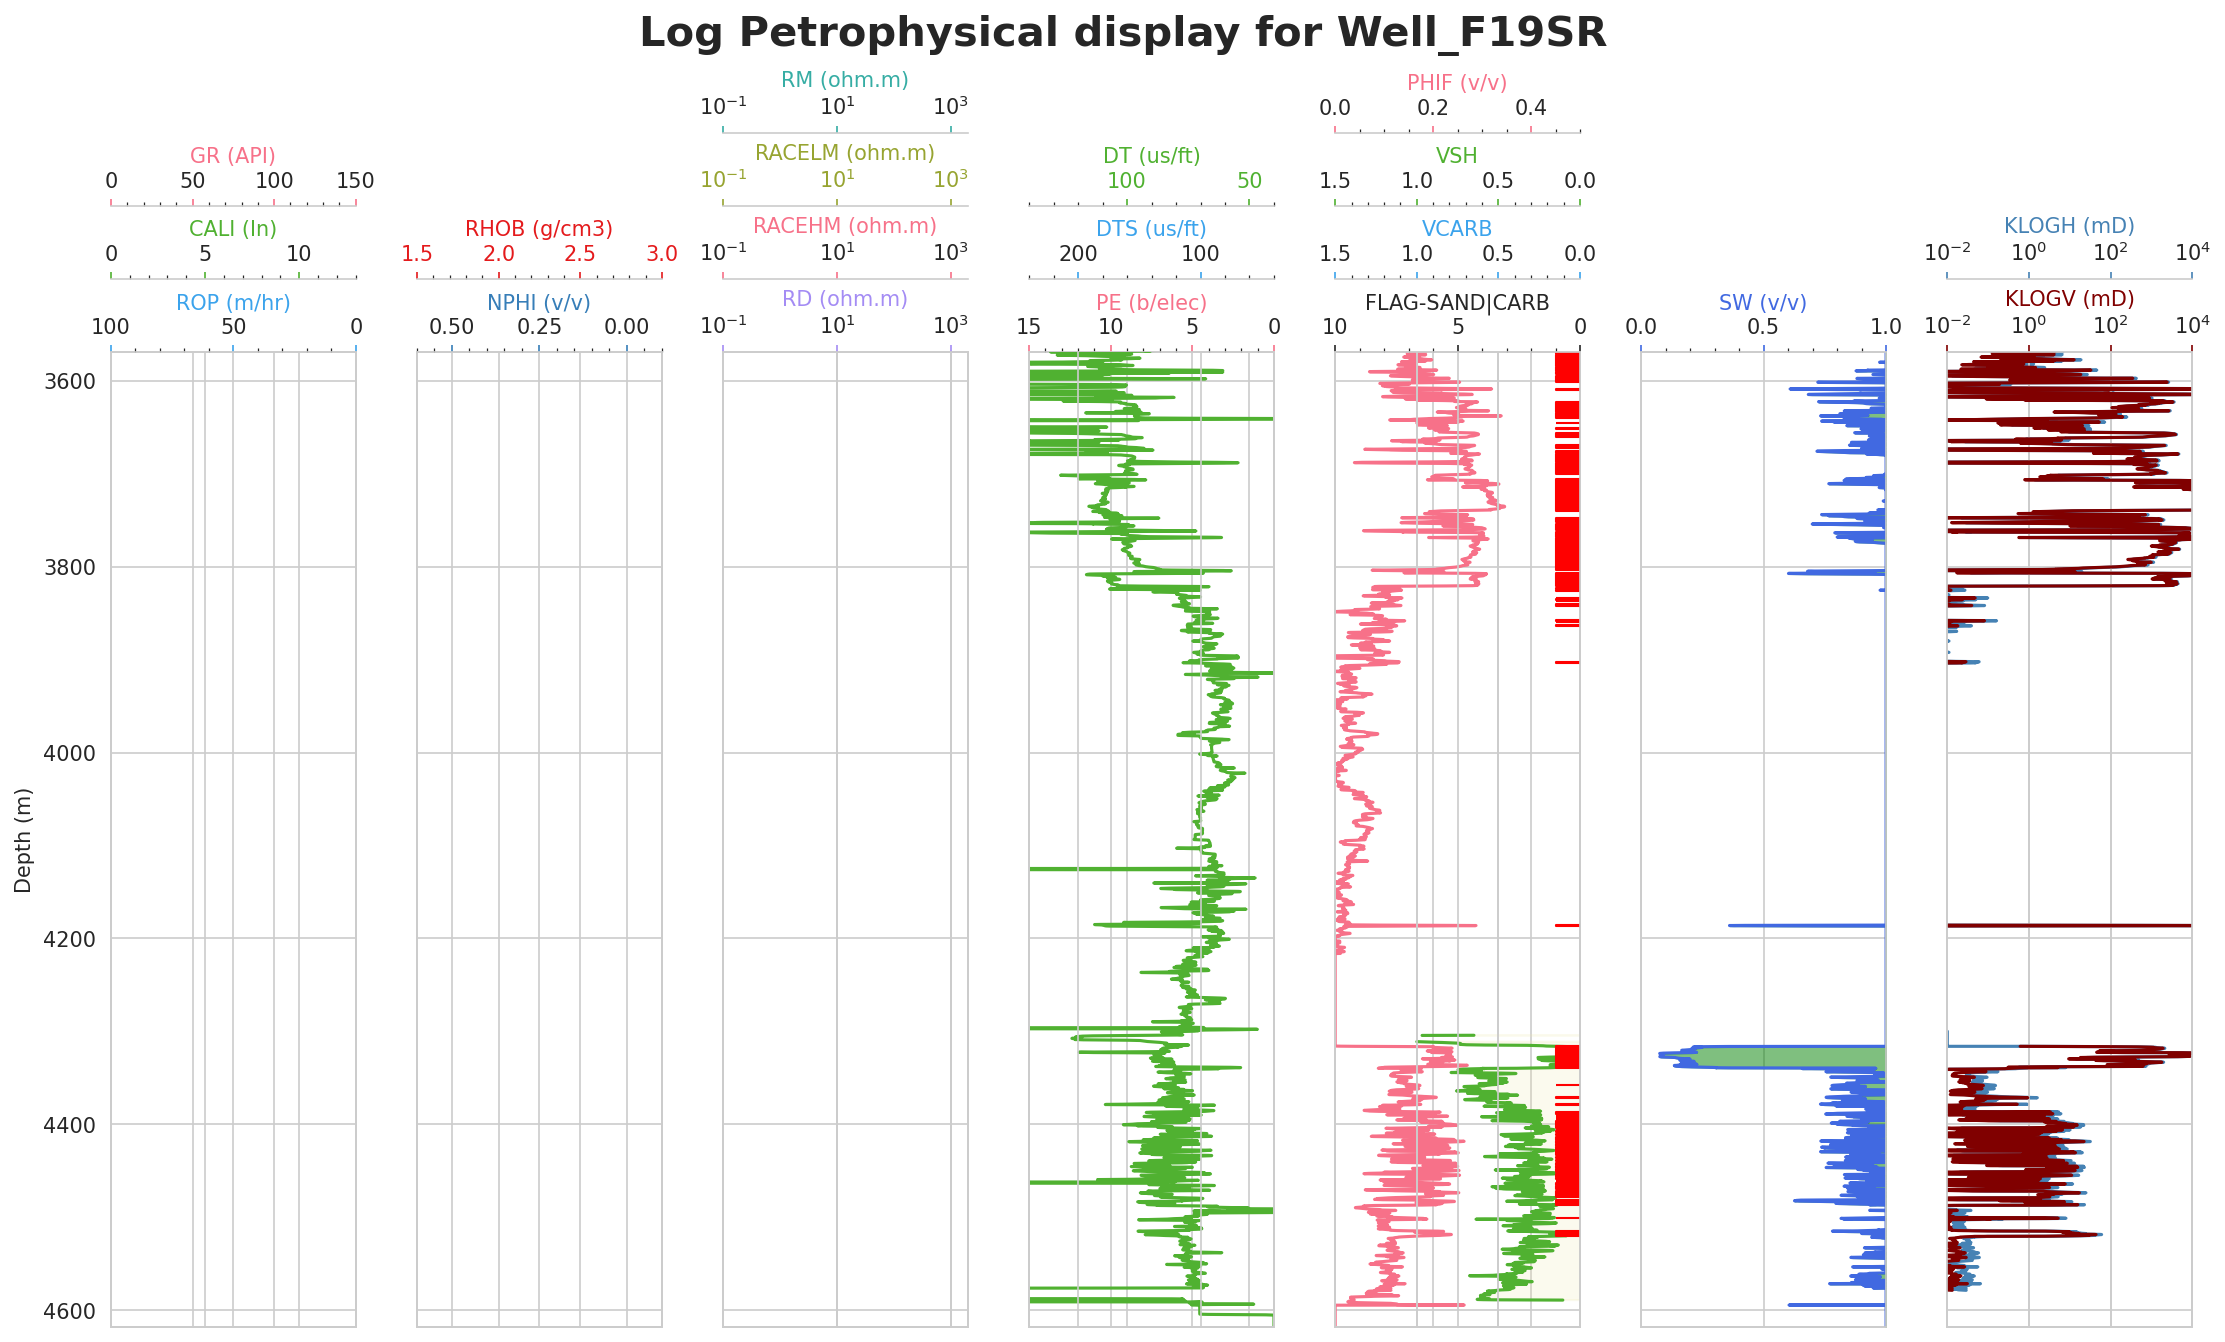

In [39]:
# generate plots for first three wells

for well in n_wells[:3]:
    well_name=data_final[data_final['name'] == f'{well}']
    well_log_plot (well_name,depths=['TOP','BOTTOM'])

In [27]:
import matplotlib.pyplot as plt

def set_ax_style(ax,xlabel,color,xlim,position):
    """ 
    设置轴的样式
    """
    ax.set_xlabel(xlabel,color=color)
    ax.tick_params(axis='x', colors=color)
    ax.set_xlim(xlim)
    ax.spines['top'].set_position('axes', position)
    ax.minorticks_on()
    
def plot_log(ax,log,depth,color,xlim,xlabel,position):
    """ 
    在指定的轴上绘制测井曲线
    """
    ax.plot(log, depth, '-', color = color)
    set_ax_style(ax,xlabel,color,xlim,position)
    
def well_log_plot(well_logs,**kwargs):
    # 省略了部分设置和准备代码...
    fig, axs = plt.subplots(nrows=1, ncols=7, sharey=True, squeeze=True, figsize=(15, 10), gridspec_kw={'wspace': 0.25})
    # 设置共享的轴标签
    axs[0].set_ylabel('Depth (m)')
    
    # 第一个轴(例子)
    ax1 = axs[0].twiny()
    plot_log(ax1,well_logs.GR,well_logs.DEPTH,'olive',[0,150],'GR (API)',1.15)
    
    # 重复上述逻辑，绘制其他轴...
    
    # 增加图例和标注 (如果需要)
    # ax.legend() ... 
    
    # 添加图标标题和保存逻辑
    plt.suptitle("Well Log Visualization", weight='bold', fontsize=20, y=0.925)
    # 如果需要保存...
    plt.show()
    
# 假设 well_logs 是已经准备好的DataFrame，包含必要的测井曲线数据... 
# well_log_plot(well_logs)

测井曲线绘制结构：

1. 参数处理；
2. 图像创建；
3. 数据绘制；
4. 图像标题和保存。

参数控制：显示深度范围 + 图像保存。

绘图高级功能：

1. twiny()方法创建共享y轴（深度轴）但具有独立x轴（测量值）的多个图轴。
2. fill_between() 填充特定条件下的区域。

In [40]:

def sort_and_set_depth_range(well_logs,depths):
    """ 
    对测井数据进行排序，并设置深度范围
    """
    well_logs = well_logs.sort_values(by='DEPTH')
    dtop=well_logs.DEPTH.min()
    dbot=well_logs.DEPTH.max()
    
    if depths[0] in ['TOP','topfm'] or depths[-1] in ['BOTTOM','bottomfm']:
        if well_logs.PHIF.isnull().sum()!=len(well_logs):
            depths[0]=well_logs.DEPTH[well_logs.PHIF.first_valid_index()]  #make the first non-NA/null value in PHIF column
            if depths[0]>=dbot:
                depths[0]=dtop
            depths[-1] = max(well_logs.DEPTH[well_logs.PHIF.last_valid_index()], dbot)
        else:
            depths[0]=dtop
            depths[-1]=dbot
    elif depths[-1]>dbot:
        depths[-1]=dbot
    elif depths[0]<dtop:
        depths[0]=dtop
    return well_logs,depths


#%% Plotting function
def well_log_plot(well_logs,**kwargs):
    
    
    # # Sort well_logs by depth
    # well_logs = well_logs.sort_values(by='DEPTH')
    # dtop=well_logs.DEPTH.min()
    # dbot=well_logs.DEPTH.max()
    # depths=kwargs.setdefault('depths',[dtop,dbot])
    

    # savefile=kwargs.setdefault('savefig',"")
    

    # if depths[0] in ['TOP','topfm'] or depths[-1] in ['BOTTOM','bottomfm']:
    #     if well_logs.PHIF.isnull().sum()!=len(well_logs):
    #         depths[0]=well_logs.DEPTH[well_logs.PHIF.first_valid_index()]  #make the first non-NA/null value in PHIF column
    #         if depths[0]>=dbot:
    #             depths[0]=dtop
    #         depths[-1] = max(well_logs.DEPTH[well_logs.PHIF.last_valid_index()], dbot)
    #     else:
    #         depths[0]=dtop
    #         depths[-1]=dbot
    # elif depths[-1]>dbot:
    #     depths[-1]=dbot
    # elif depths[0]<dtop:
    #     depths[0]=dtop
    
    # 可能传入的参数：
    # 1. depths: 深度范围
    # 2. savefig: 保存文件名
    
    
    # 排序和深度范围设置:
    well_logs = well_logs.sort_values(by='DEPTH')
    dtop=well_logs['DEPTH'].min()
    dbot=well_logs['DEPTH'].max()
    depths=kwargs.setdefault('depths',[dtop,dbot])
    
    savefile=kwargs.setdefault('savefig',"")
    
    # 检查特殊深度标记并调整
    if depths[0] in ['TOP','topfm'] or depths[-1] in ['BOTTOM','bottomfm']:
        if 
    
    fig, axs = plt.subplots(nrows=1, ncols=7, sharey=True, squeeze=True, figsize=(15, 10), gridspec_kw={'wspace': 0.25})
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.975, top=0.7, wspace=0.2, hspace=0.2)
    axs[0].set_ylabel('Depth (m)')
    for ax in axs:
        ax.set_ylim(depths[0],depths[-1])
        ax.invert_yaxis()
        ax.grid(True)
        ax.locator_params(axis='x', nbins=5)
        ax.get_xaxis().set_visible(False)
    


    # First track GR/CALI/ROP logs to display
    ax1 = axs[0].twiny()
    ax1.plot(well_logs.GR, well_logs.DEPTH, '-', color='olive')
    ax1.set_xlim(0,150)
    ax1.set_xlabel('GR (API)', color='olive')
    ax1.minorticks_on()
    ax1.tick_params(axis='x', color='olive')
    ax1.spines['top'].set_position(("axes", 1.15)) # Move the last y-axis spine over to the top by 20% of the width of the axes

    ax2 = axs[0].twiny()
    ax2.plot(well_logs.CALI, well_logs.DEPTH, '-', color='magenta')
    ax2.set_xlim(0,13)
    ax2.set_xlabel('CALI (In)', color='magenta')
    ax2.minorticks_on()
    ax2.tick_params(axis='x', color='magenta')
    ax2.spines['top'].set_position(("axes", 1.075))

    ax3 = axs[0].twiny()
    ax3.plot(well_logs.ROP, well_logs.DEPTH, '-', color='slateblue')
    ax3.set_xlim(100,0)
    ax3.set_xlabel('ROP (m/hr)', color='slateblue')
    ax3.minorticks_on()
    ax3.tick_params(axis='x', color='slateblue')
    ax3.spines['top'].set_position(("axes", 1.0))

    # Second track NPHI/RHOB logs to display
    ax1 = axs[1].twiny()
    ax1.plot(well_logs.RHOB, well_logs.DEPTH, '-', color='blue')
    ax1.set_xlim(1.5,3)
    ax1.set_xlabel('RHOB (g/cm3)', color='blue')
    ax1.tick_params(axis='x', colors='blue')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(("axes", 1.075))

    ax2 = axs[1].twiny()
    ax2.plot(well_logs.NPHI, well_logs.DEPTH, '-', color='forestgreen')
    ax2.set_xlim(0.6,-0.1)
    ax2.set_xlabel('NPHI (v/v)', color='forestgreen')
    ax2.tick_params(axis='x', color='forestgreen')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(("axes", 1.0))

    # Third track Resistivity logs to display
    ax1 = axs[2].twiny()
    ax1.plot(well_logs.RACEHM, well_logs.DEPTH, '-', color='lime')
    ax1.grid(True)
    ax1.set_xlim(0.1,2000)
    ax1.set_xlabel('RACEHM (ohm.m)', color='lime')
    ax1.tick_params(axis='x', color='lime')
    ax1.set_xscale('log')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(("axes", 1.075))

    ax2 = axs[2].twiny()
    ax2.plot(well_logs.RACELM, well_logs.DEPTH, '-', color='darkviolet')
    ax2.set_xlim(0.1,2000)
    ax2.set_xlabel('RACELM (ohm.m)', color='darkviolet')
    ax2.tick_params(axis='x', colors='darkviolet')
    ax2.set_xscale('log')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(("axes", 1.15))

    ax3 = axs[2].twiny()
    ax3.plot(well_logs.RM, well_logs.DEPTH, '-', color='darkblue')
    ax3.set_xlim(0.1,2000)
    ax3.set_xlabel('RM (ohm.m)', color='darkblue')
    ax3.tick_params(axis='x', color='darkblue')
    ax3.set_xscale('log')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(("axes", 1.225))

    ax4 = axs[2].twiny()
    ax4.plot(well_logs.RD, well_logs.DEPTH, '-', color='cyan')
    ax4.set_xlim(0.1,2000)
    ax4.set_xlabel('RD (ohm.m)', color='cyan')
    ax4.tick_params(axis='x', color='cyan')
    ax4.set_xscale('log')
    ax4.minorticks_on()
    ax4.spines['top'].set_position(("axes", 1.0))

    # Forth track DTC/DTS/PEF logs to display
    ax1 = axs[3].twiny()
    ax1.plot(well_logs.PEF, well_logs.DEPTH, '-', color='grey')
    ax1.set_xlim(15,0)
    ax1.set_xlabel('PE (b/elec)', color='grey')
    ax1.tick_params(axis='x', color='grey')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(("axes", 1.0))

    ax2 = axs[3].twiny()
    ax2.plot(well_logs.DT, well_logs.DEPTH, '-', color='orange')
    ax2.set_xlim(140,40)
    ax2.set_xlabel('DT (us/ft)', color='orange')
    ax2.tick_params(axis='x', colors='orange')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(("axes", 1.15))

    ax3 = axs[3].twiny()
    ax3.plot(well_logs.DTS, well_logs.DEPTH, '-', color='red')
    ax3.set_xlim(240,40)
    ax3.set_xlabel('DTS (us/ft)', color='red')
    ax3.tick_params(axis='x', color='red')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(("axes", 1.075))

    # Fifth track PHIF logs to display
    ax1 = axs[4].twiny()
    ax1.plot(well_logs.PHIF, well_logs.DEPTH, '-', color='peru')
    ax1.set_xlim(0,0.5)
    ax1.grid(True)
    ax1.set_xlabel('PHIF (v/v)', color='peru')
    ax1.tick_params(axis='x', color='peru')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(("axes", 1.225))

    ax2 = axs[4].twiny()
    ax2.plot(well_logs.VSH, well_logs.DEPTH, '-', color='palegoldenrod')
    ax2.set_xlim(1.5,0)
    ax2.set_xlabel('VSH', color='palegoldenrod')
    ax2.tick_params(axis='x', color='palegoldenrod')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(("axes", 1.15))
    ax2.fill_betweenx(well_logs.DEPTH, well_logs.VSH, 0, where=(well_logs.VSH > 0), color='palegoldenrod', alpha=0.2)

    ax4 = axs[4].twiny()
    ax4.plot(well_logs.VCARB, well_logs.DEPTH, '-', color='olivedrab')
    ax4.set_xlim(1.5,0)
    ax4.set_xlabel('VCARB', color='olivedrab')
    ax4.tick_params(axis='x', color='olivedrab')
    ax4.minorticks_on()
    ax4.spines['top'].set_position(("axes", 1.075))
    ax4.fill_betweenx(well_logs.DEPTH, well_logs.VCARB, 0, where=(well_logs.VCARB > 0), color='olivedrab', alpha=0.2)

    ax3 = axs[4].twiny()
    ax3.fill_betweenx(well_logs.DEPTH, well_logs.SAND_FLAG, 0, where=(well_logs.SAND_FLAG > 0), color='red')
    ax3.fill_betweenx(well_logs.DEPTH, well_logs.CARB_FLAG, 0, where=(well_logs.CARB_FLAG > 0), color='lime')
    ax3.fill_betweenx(well_logs.DEPTH, well_logs.COAL_FLAG, 0, where=(well_logs.COAL_FLAG > 0), color='black')
    ax3.set_xlim(10,0)
    ax3.set_xlabel('FLAG-SAND|CARB')
    ax3.tick_params(axis='x')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(("axes", 1.0))

    # Sixth track SW logs to display
    ax1 = axs[5].twiny()
    ax1.plot(well_logs.SW, well_logs.DEPTH, '-', color='royalblue')
    ax1.grid(True)
    ax1.set_xlim(0,1)
    ax1.set_xlabel('SW (v/v)', color='royalblue')
    ax1.tick_params(axis='x', color='royalblue')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(("axes", 1.0))
    ax1.fill_betweenx(
        well_logs.DEPTH,
        well_logs.SW,
        1,
        where=well_logs.SW <= 1,
        color='green',
        alpha=0.5,
    )

    # Seventh track KLOGH/KLOGV logs to display
    ax1 = axs[6].twiny()
    ax1.set_xscale('log')
    ax1.grid(True)
    ax1.plot(well_logs.KLOGH, well_logs.DEPTH, '-', color='steelblue')
    ax1.set_xlim(0.01,10000)
    ax1.set_xlabel('KLOGH (mD)', color='steelblue')
    ax1.tick_params(axis='x', color='steelblue')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(("axes", 1.075))

    ax2 = axs[6].twiny()
    ax2.set_xscale('log')
    ax2.plot(well_logs.KLOGV, well_logs.DEPTH, '-', color='maroon')
    ax2.set_xlim(0.01,10000)
    ax2.set_xlabel('KLOGV (mD)', color='maroon')
    ax2.tick_params(axis='x', color='maroon')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(("axes", 1.0))

    fig.suptitle(
        f"Log Petrophysical display for {well_logs.iloc[0]['WELL_NAME']}",
        weight='bold',
        fontsize=20,
        y=0.925,
    )
    if len(savefile)>0:
        fig.savefig(savefile,dpi=300)